# Military and Civilian Vehicles Classification

## Data Set Introduction

- The dataset consists of images of various vehicles of two types, military and civilian. There 6772 images in total. 717 of them belongs to test set and the rest belongs to train set. Each image is labeled according to the vehicle type, which is very important for training the classification model. The classes are as follows:

    - Civilian aircraft
    - Civilian car
    - Military aircraft
    - Military helicopter
    - Military tank
    - Military truck

#### The features that our dataset have:

filename : Names of the images that are in the Images folder to be used for the project.\
width : Number of pixels that images have as their width.\
height : Number of pixels that images have as their height.\
class : The category that objects in the images are belongs to.\
xmin : Position of the objects left edge in the image.\
xmax : Position of the objects right edge in the image.\
ymin : Position of the objects lower edge in the image.\
ymax : Position of the objects upper edge in the image.

## Description of the Problem

- The project aims to build a classifier to predict vehicle types based on visual data. The approach involves exploring various models such as EfficientNet, DenseNet and ResNet to determine the best-performing model.
- Key questions addressed include:
  - How can we accurately classify images of vehicles into their respective categories?
  - What preprocessing techniques enhance model performance?
  - What types of models can be used in image classification?
  - How do different models compare in terms of accuracy and efficiency?

## Data Exploration
- Visualizations were created to provide insights into the data, such as the number of images per class. This helped in identifying any class imbalances and understanding the data better.
- Duplicated datas were checked and removed due to prevent any repetitive information during the training process.
- Null values are controlled to see if we have any missing information. Despite of the checking, there was not a null value in our dataset so we did not have to drop any of the rows.

## Methodologies

- Data preprocessing techniques included resizing images to a uniform size (400x250 pixels), normalizing pixel values, and augmenting the dataset to improve model robustness.
- The project utilized PyTorch for model training, employing transfer learning with pre-trained models. Hyperparameter tuning was performed using Optuna to optimize model performance.
- Deep neural networks (DNNs) are ideal for image classification because they can automatically learn hierarchical feature representations from raw pixel data, enabling them to recognize complex patterns and objects in images. DenseNet, EfficientNet, and ResNet are particularly effective choices because DenseNet supports efficient feature reuse with its dense connections, improving performance and reducing parameters; EfficientNet balances network depth, width, and resolution to maximize accuracy while minimizing computational cost; and ResNet uses residual connections to allow much deeper networks to be trained without suffering from vanishing gradients, increasing the model’s ability to learn complex features from large datasets. Therefore, these three models were used for model selection.
- An ensemble model was developed by combining predictions from multiple models to improve accuracy. The ensemble approach averaged the outputs of the individual models, leading to better performance on the test set.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import optuna
from optuna.trial import Trial
import warnings
from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

warnings.filterwarnings("ignore")

# Constants
IMG_SIZE_X = 400
IMG_SIZE_Y = 250
BATCH_SIZE = 32
EPOCHS = 10


In [2]:
def download_folder_from_drive(folder_link, destination_folder, service_account_file):
    # Authenticate using the service account JSON key file
    credentials = service_account.Credentials.from_service_account_file(
        service_account_file, scopes=['https://www.googleapis.com/auth/drive']
    )
    
    # Create the Drive API client
    drive_service = build('drive', 'v3', credentials=credentials)
    
    # Extract the folder ID from the link
    folder_id = folder_link.split('/')[-1].split('?')[0]  # Remove query parameters
    
    # Get the name of the main folder
    folder_metadata = drive_service.files().get(fileId=folder_id, fields='name').execute()
    folder_name = folder_metadata['name']
    
    # Create the main destination folder
    main_destination_folder = os.path.join(destination_folder, folder_name)
    if not os.path.exists(main_destination_folder):
        os.makedirs(main_destination_folder)
    
    # Recursively download the folder and its subfolders
    download_folder_recursive(drive_service, folder_id, main_destination_folder)
    print('Download complete!')

def download_folder_recursive(drive_service, folder_id, destination_folder):
    page_token = None
    while True:
        # Query for files and subfolders in the folder
        results = drive_service.files().list(
            q=f"'{folder_id}' in parents and trashed=false",
            fields="nextPageToken, files(id, name, mimeType)",
            pageSize=1000,  # Maximum number of items per page
            pageToken=page_token
        ).execute()
        
        items = results.get('files', [])
        
        for item in items:
            item_id = item['id']
            item_name = item['name']
            mime_type = item['mimeType']
            
            # If the item is a folder, recursively download it
            if mime_type == 'application/vnd.google-apps.folder':
                subfolder_path = os.path.join(destination_folder, item_name)
                if not os.path.exists(subfolder_path):  # Check if folder already exists
                    os.makedirs(subfolder_path)
                download_folder_recursive(drive_service, item_id, subfolder_path)
            else:
                # If the item is a file, download it
                print(f'Downloading {item_name}...')
                download_file(drive_service, item_id, item_name, destination_folder)
        
        # Check if there are more pages
        page_token = results.get('nextPageToken')
        if not page_token:
            break

def download_file(drive_service, file_id, file_name, destination_folder):
    # Download binary files directly
    request = drive_service.files().get_media(fileId=file_id)
    
    # Save the file
    with open(os.path.join(destination_folder, file_name), 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
            print(f"Download {int(status.progress() * 100)}% complete.")

# Your specific folder link and destination folder
folder_link = 'https://drive.google.com/drive/folders/19zN-tfE5l95oTFO84kqXiaULpq3qTusb?usp=drive_link'
destination_folder = os.getcwd()
service_account_file = 'client_secret.json'  # Replace with the path to your JSON key file

# Call the function
download_folder_from_drive(folder_link, destination_folder, service_account_file)

Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% complete.
Download 100% co

In [3]:
#Data Preprocessing
def preprocess_df(df):
    # Group multiple objects in same image
    df_grouped = df.groupby('filename').agg({
        'width': 'first',
        'height': 'first',
        'class': list,
        'xmin': list,
        'ymin': list,
        'xmax': list,
        'ymax': list
    }).reset_index()
    
    # Get primary class
    df_grouped['primary_class'] = df_grouped['class'].apply(
        lambda x: max(set(x), key=x.count)
    )
    
    # Calculate object counts per image
    df_grouped['object_count'] = df_grouped['class'].apply(len)
    
    # Calculate average object size
    df_grouped['avg_obj_size'] = df_grouped.apply(
        lambda row: np.mean([(xmax-xmin)*(ymax-ymin) for xmin, ymin, xmax, ymax in 
                           zip(row['xmin'], row['ymin'], row['xmax'], row['ymax'])]), axis=1
    )
    
    return df_grouped

def validate_images(df, image_dir):
    valid_files = []
    for filename in df['filename']:
        if os.path.exists(os.path.join(image_dir, filename)):
            valid_files.append(filename)
    return df[df['filename'].isin(valid_files)].reset_index(drop=True)



In [4]:
#Dataset Classes
class PreprocessDataset(Dataset):
    def __init__(self, df, image_dir):
        self.df = df
        self.image_dir = image_dir
        self.classes = sorted(df['primary_class'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((IMG_SIZE_Y, IMG_SIZE_X)),
            transforms.RandomRotation(30),
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1
            ),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['filename']
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Check if the image is already resized
        if image.shape[0] != IMG_SIZE_Y or image.shape[1] != IMG_SIZE_X:
            image = cv2.resize(image, (IMG_SIZE_X, IMG_SIZE_Y))
        
        
        image = self.transform(image)
        label = self.class_to_idx[self.df.iloc[idx]['primary_class']]
        
        return {
            'image': image,
            'label': label,
            'filename': img_name
        }

class ProcessedDataset(Dataset):
    def __init__(self, data_dir, is_test=False, image_dir=None, df=None):
        self.data_dir = data_dir
        self.is_test = is_test
        self.image_dir = image_dir
        self.df = df
        
        if not self.is_test:
            self.files = [f for f in os.listdir(data_dir) if f.endswith('.pt')]
            self.class_mapping = torch.load('processed_data/class_mapping.pt')
        else:
            self.files = df['filename'].tolist()
            self.class_mapping = torch.load('processed_data/class_mapping.pt')
        
        self.classes = list(self.class_mapping.keys())
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        if not self.is_test:
            data = torch.load(os.path.join(self.data_dir, self.files[idx]))
            return data['image'], data['label']
        else:
            img_name = self.files[idx]
            img_path = os.path.join(self.image_dir, img_name)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE_X, IMG_SIZE_Y))
            
            # Apply the same transformations as in PreprocessDataset
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((IMG_SIZE_Y, IMG_SIZE_X)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                  std=[0.229, 0.224, 0.225])
            ])
            image = transform(image)
            
            label = self.class_mapping[self.df[self.df['filename'] == img_name]['primary_class'].values[0]]
            
            return image, label



In [5]:
class ModelFactory:
    @staticmethod
    def create_model(model_name, num_classes, dropout_rate, num_layers_unfrozen):
        # Load the pre-trained base model
        if model_name == 'efficientnet':
            base_model = models.efficientnet_b0(pretrained=True)
            num_features = base_model.classifier[1].in_features
        elif model_name == 'densenet':
            base_model = models.densenet121(pretrained=True)
            num_features = base_model.classifier.in_features
        elif model_name == 'resnet':
            base_model = models.resnet50(pretrained=True)
            num_features = base_model.fc.in_features
        else:
            raise ValueError(f"Unknown model: {model_name}")

        # Freeze all layers initially
        for param in base_model.parameters():
            param.requires_grad = False

        # Unfreeze the last `num_layers_unfrozen` layers
        if model_name == 'efficientnet':
            # EfficientNet: Unfreeze layers in the `features` block
            for param in list(base_model.features.parameters())[-num_layers_unfrozen:]:
                param.requires_grad = True
        elif model_name == 'densenet':
            # DenseNet: Unfreeze layers in the `features` block
            for param in list(base_model.features.parameters())[-num_layers_unfrozen:]:
                param.requires_grad = True
        elif model_name == 'resnet':
            # ResNet: Unfreeze layers in the `layer4` block (last residual block)
            for param in list(base_model.layer4.parameters())[-num_layers_unfrozen:]:
                param.requires_grad = True

        # Create classifier
        classifier = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )

        # Replace the classifier/fully connected layer
        if model_name == 'efficientnet':
            base_model.classifier = classifier
        elif model_name == 'densenet':
            base_model.classifier = classifier
        elif model_name == 'resnet':
            base_model.fc = classifier

        return base_model

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, scheduler=None, early_stopping_patience=5):
    model = model.to(device)
    best_val_acc = 0
    no_improve = 0
    history = {
        'train_loss': [], 'train_acc': [], 
        'val_loss': [], 'val_acc': [],
        'learning_rate': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Update learning rate scheduler
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)  # For ReduceLROnPlateau, step with validation loss
            else:
                scheduler.step()  # For other schedulers, step normally
        
        # Calculate metrics
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rate'].append(current_lr)
        
        # Print metrics
        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}')
        print(f'Learning Rate: {current_lr:.6f}')
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            no_improve = 0
        else:
            no_improve += 1
            
        if no_improve >= early_stopping_patience:
            print("\nEarly stopping triggered")
            break
    
    return best_val_acc, history

In [7]:
# Read and preprocess data
train_df = pd.read_csv('Military and Civilian Vehicles Dataset/Labels/CSV Format/train_labels.csv')
test_df = pd.read_csv('Military and Civilian Vehicles Dataset/Labels/CSV Format/test_labels.csv')

In [8]:
# Display the first few rows of the training DataFrame
print("Training DataFrame:")
train_df.head(10)

Training DataFrame:


filename  width  height  \
0              000_14M0LD-e1525732547750-400x250.jpg    400     250   
1              000_14M0LD-e1525732547750-400x250.jpg    400     250   
2                           000_1H95VB.width-800.jpg    800     532   
3             000_1LC27X-e1570900274807-1024x640.jpg   1024     640   
4             000_1LC27X-e1570900274807-1024x640.jpg   1024     640   
5                         0023ae82ca0f1487c33a46.jpg    900     618   
6  01-BOAC-Comet-1-G-BOAC-AI-PM-1953-0603-Marvin-...   1626    1038   
7                        01-honda-civic-si-sedan.jpg   2480    1600   
8                                0101020114.side.jpg    918     516   
9                             010205-F-1631A-001.jpg    780     512   

               class  xmin  ymin  xmax  ymax  
0      military tank   121    60   220   144  
1      military tank   198   108   371   197  
2  military aircraft    30   168   622   505  
3      military tank    78    92   858   563  
4     military truck   816   288  1012   554  
5  civilian aircraft     5    62   857   590  
6  civilian aircraft   115   375  1593   784  
7       civilian car   731   551  2222  1385  
8       civilian car   108   160   815   413  
9  military aircraft    81   185   701   411

In [9]:
train_df.shape # Before removing duplicate rows

(10716, 8)

In [10]:
train_df.duplicated().sum() # Check and Count how many duplicate rows do we have

36

In [11]:
train_df = train_df[train_df.duplicated()==False] # Remove duplicated data

In [12]:
train_df.isnull().sum().sum() # Null Value Check

0

In [13]:
train_df.shape # After removing duplicate rows

(10680, 8)

In [14]:
# Display the first few rows of the testing DataFrame
print("\nTesting DataFrame:")
test_df.head(10)


Testing DataFrame:


filename  width  height  \
0              000_14M0LD-e1525732547750-400x250.jpg    400     250   
1              000_14M0LD-e1525732547750-400x250.jpg    400     250   
2                           000_1H95VB.width-800.jpg    800     532   
3             000_1LC27X-e1570900274807-1024x640.jpg   1024     640   
4             000_1LC27X-e1570900274807-1024x640.jpg   1024     640   
5  01-BOAC-Comet-1-G-BOAC-AI-PM-1953-0603-Marvin-...   1626    1038   
6                        01-honda-civic-si-sedan.jpg   2480    1600   
7  0b28dfae627833f2697dddd956d57558--panzer-iv-mi...    235     179   
8               0c1a3269dca7c2a3cddec316466b39a0.jpg    500     333   
9               0de8a1c1ce19bc38c5c6b79aca6f074c.jpg   1024     683   

                 class  xmin  ymin  xmax  ymax  
0        military tank   121    60   220   144  
1        military tank   198   108   371   197  
2    military aircraft    30   168   622   505  
3        military tank    78    92   858   563  
4       military truck   816   288  1012   554  
5    civilian aircraft   115   375  1593   784  
6         civilian car   731   551  2222  1385  
7        military tank    18    26   221   121  
8  military helicopter    67    18   471   300  
9    civilian aircraft    52    90   954   506

In [15]:
# Validate and clean data
image_dir = 'Military and Civilian Vehicles Dataset/Images/'
train_df = validate_images(train_df, image_dir)
test_df = validate_images(test_df, image_dir)

train_df_processed = preprocess_df(train_df)
test_df_processed = preprocess_df(test_df)

# Create validation split
train_data, val_data = train_test_split(
    train_df_processed, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df_processed['primary_class']
)


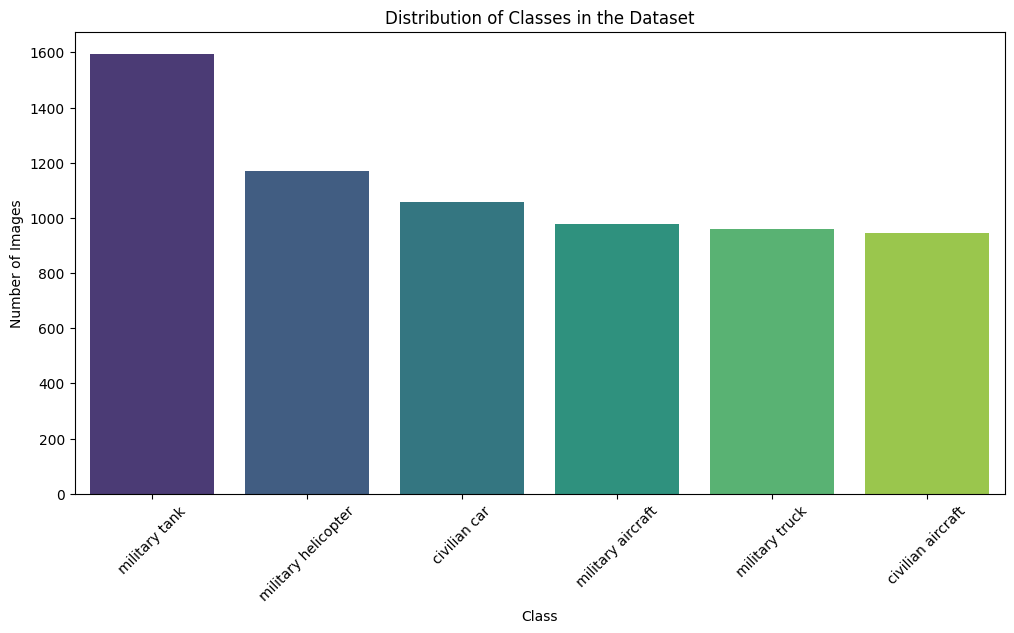

In [16]:
# Plot class distribution
class_distribution = train_df_processed['primary_class'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Distribution of Classes in the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.savefig('images/class_distribution.png')  # Save the plot
plt.show()

In [17]:
def visualize_augmentations(image_dir, df, num_samples=5):
   """Visualize different augmentations of the same image"""
   # Create dataset with real-time augmentations
   dataset = PreprocessDataset(df, image_dir)
   
   plt.figure(figsize=(20, 4*num_samples))
   
   # Get random indices
   indices = np.random.choice(len(dataset), num_samples, replace=False)
   
   for idx, sample_idx in enumerate(indices):
       # Get the original image without augmentations
       img_name = df.iloc[sample_idx]['filename']
       img_path = os.path.join(image_dir, img_name)
       original_img = cv2.imread(img_path)
       original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
       original_img = cv2.resize(original_img, (IMG_SIZE_X, IMG_SIZE_Y))
       
       # Show original image
       plt.subplot(num_samples, 5, idx*5 + 1)
       plt.imshow(original_img / 255.0)  # Normalize to [0,1]
       plt.title('Original')
       plt.axis('off')
       
       # Show 4 different augmentations
       for aug_idx in range(4):
           # Get a new augmented version
           augmented = dataset[sample_idx]
           aug_img = augmented['image']
           
           # Convert tensor to numpy and denormalize
           aug_img_np = aug_img.permute(1, 2, 0).numpy()
           aug_img_np = std * aug_img_np + mean
           aug_img_np = np.clip(aug_img_np, 0, 1)
           
           plt.subplot(num_samples, 5, idx*5 + aug_idx + 2)
           plt.imshow(aug_img_np)
           plt.title(f'Augmentation {aug_idx+1}')
           plt.axis('off')
   
   plt.tight_layout()
   plt.savefig('images/augmentation_examples.png')
   plt.show()
# Normalization constants
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [18]:
# Create processed data directory
os.makedirs('processed_data/train', exist_ok=True)
os.makedirs('processed_data/val', exist_ok=True)
os.makedirs('processed_data/test', exist_ok=True)

# Process and save training data
print("Processing training data...")
train_dataset = PreprocessDataset(train_data, image_dir)
for idx in range(len(train_dataset)):
    data = train_dataset[idx]
    torch.save(data, f'processed_data/train/train_{idx}.pt')
    if idx % 100 == 0:
        print(f"Processed {idx}/{len(train_dataset)} training images")

# Process and save validation data
print("\nProcessing validation data...")
val_dataset = PreprocessDataset(val_data, image_dir)
for idx in range(len(val_dataset)):
    data = val_dataset[idx]
    torch.save(data, f'processed_data/val/val_{idx}.pt')
    if idx % 100 == 0:
        print(f"Processed {idx}/{len(val_dataset)} validation images")

# Save class mapping
torch.save(train_dataset.class_to_idx, 'processed_data/class_mapping.pt')
print("\nPreprocessing complete!")



Processing training data...
Processed 0/5360 training images
Processed 100/5360 training images
Processed 200/5360 training images
Processed 300/5360 training images
Processed 400/5360 training images
Processed 500/5360 training images
Processed 600/5360 training images
Processed 700/5360 training images
Processed 800/5360 training images
Processed 900/5360 training images
Processed 1000/5360 training images
Processed 1100/5360 training images
Processed 1200/5360 training images
Processed 1300/5360 training images
Processed 1400/5360 training images
Processed 1500/5360 training images
Processed 1600/5360 training images
Processed 1700/5360 training images
Processed 1800/5360 training images
Processed 1900/5360 training images
Processed 2000/5360 training images
Processed 2100/5360 training images
Processed 2200/5360 training images
Processed 2300/5360 training images
Processed 2400/5360 training images
Processed 2500/5360 training images
Processed 2600/5360 training images
Processed 27

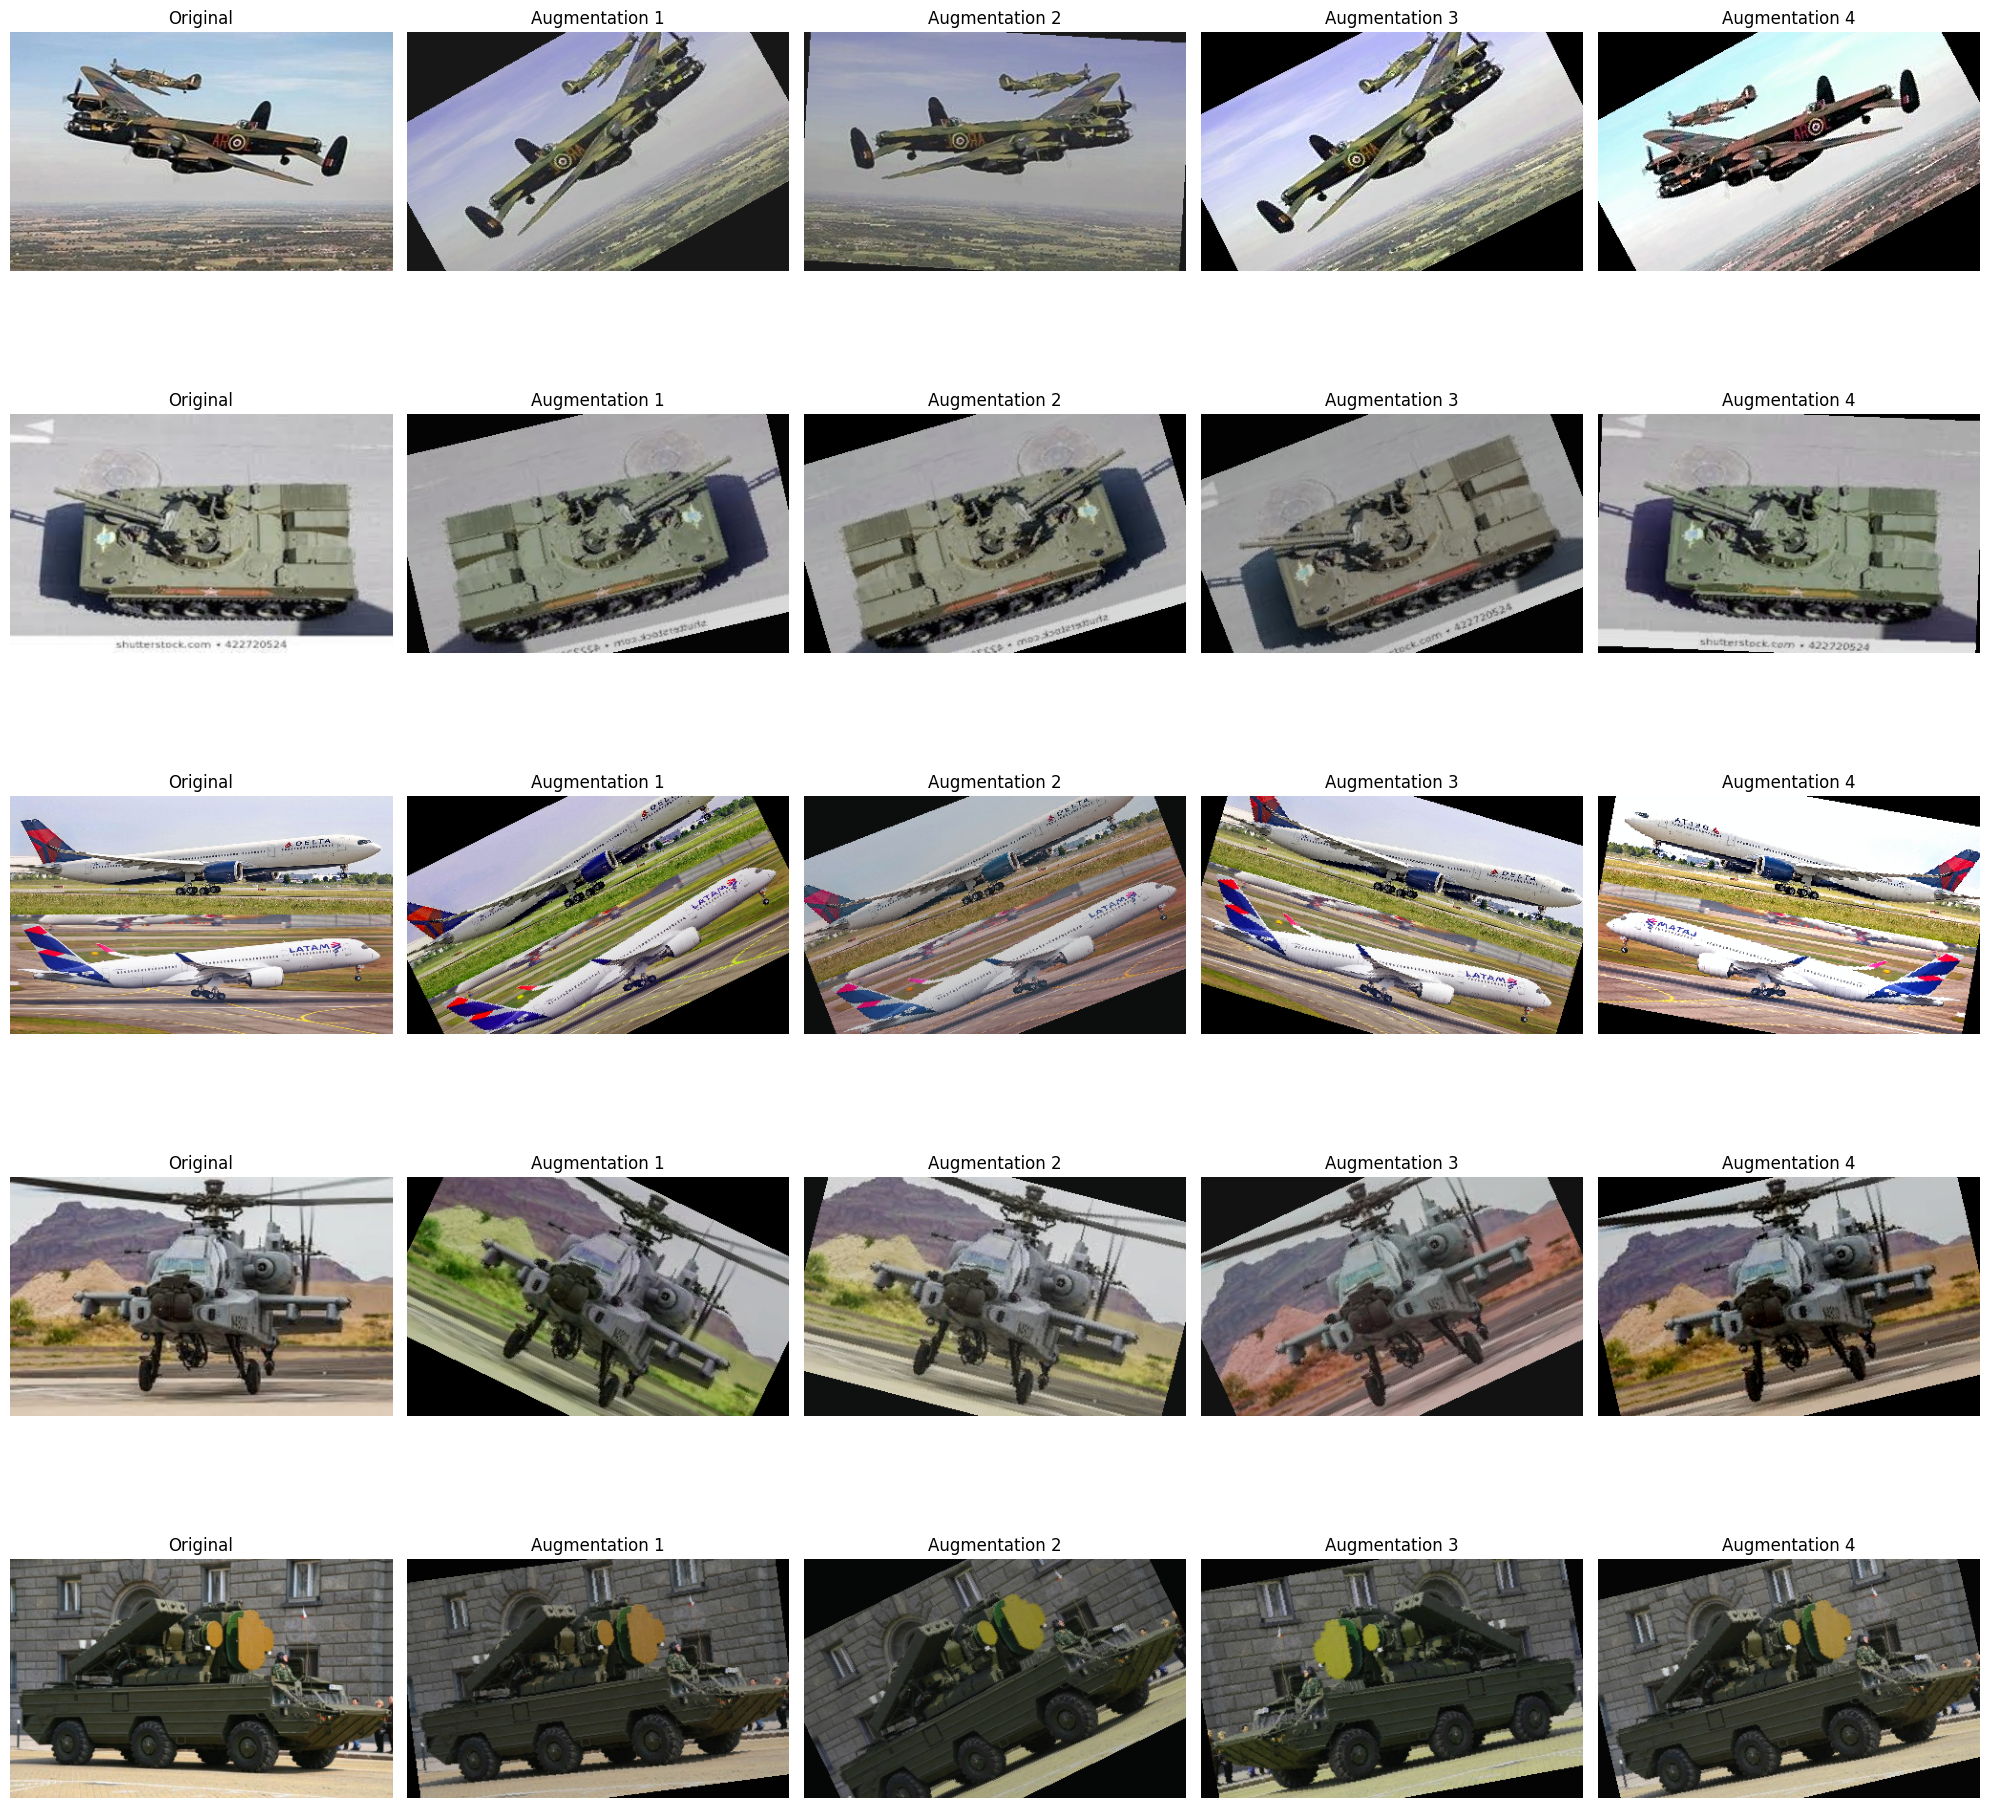

In [87]:
# Visualize augmentations
visualize_augmentations(image_dir, train_df_processed)

In [20]:
# Create datasets from processed data
train_dataset = ProcessedDataset('processed_data/train')
val_dataset = ProcessedDataset('processed_data/val')
test_dataset = ProcessedDataset(data_dir='processed_data/test', is_test=True, image_dir=image_dir, df=test_df_processed)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create results directory
os.makedirs('checkpoints', exist_ok=True)

# Initialize results
model_results = {}
best_overall_acc = 0
best_overall_model = None
best_overall_name = None
best_overall_history = None

# Models to try
models_to_try = ['efficientnet', 'densenet', 'resnet']
num_classes = len(train_dataset.classes)

Using device: cuda


In [21]:
def objective(trial: Trial, model_name):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    optimizer_type = trial.suggest_categorical("optimizer_type", ["Adam", "SGD"])
    scheduler_type = trial.suggest_categorical("scheduler_type", ["StepLR", "ReduceLROnPlateau"])
    num_layers_unfrozen = trial.suggest_int("num_layers_unfrozen", 10, 30)
    early_stopping_patience = trial.suggest_int("early_stopping_patience", 3, 7)  # Add this line

    # Create datasets and data loaders
    train_dataset = ProcessedDataset('processed_data/train')
    val_dataset = ProcessedDataset('processed_data/val')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Create model with tuned hyperparameters
    model = ModelFactory.create_model(
        model_name, 
        num_classes, 
        dropout_rate=dropout_rate,
        num_layers_unfrozen=num_layers_unfrozen  # Pass the num_layers_unfrozen parameter
    ).to(device)

    # Optimizer
    if optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == "SGD":
        momentum = trial.suggest_float("momentum", 0.8, 0.99)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Learning rate scheduler
    if scheduler_type == "StepLR":
        step_size = trial.suggest_int("step_size", 3, 10)
        gamma = trial.suggest_float("gamma", 0.1, 0.5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        patience = trial.suggest_int("patience", 2, 5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Train the model
    best_val_acc, _ = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        device, 
        EPOCHS, 
        scheduler=scheduler,
        early_stopping_patience=early_stopping_patience  # Pass the early_stopping_patience value
    )

    return best_val_acc

In [22]:
# Models to try
models_to_try = ['efficientnet', 'densenet', 'resnet']
num_classes = len(ProcessedDataset('processed_data/train').classes)

# Dictionary to store best models, their hyperparameters, and best accuracies
best_models = {}
best_params = {}
best_accuracies = {}

    
# Train each model with Optuna
for model_name in models_to_try:
    print(f"\nTuning {model_name.upper()} with Optuna...")

    # Create Optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, model_name), n_trials=10)  # 10 trials per model

    # Store the best hyperparameters
    best_params[model_name] = study.best_params
    print(f"Best hyperparameters for {model_name}: {best_params[model_name]}")

    # Train the model with the best hyperparameters
    print(f"\nTraining {model_name.upper()} with best hyperparameters...")
    
    # Create model with the best dropout rate and unfrozen layers
    model = ModelFactory.create_model(
        model_name, 
        num_classes, 
        dropout_rate=best_params[model_name]["dropout_rate"],
        num_layers_unfrozen=best_params[model_name]["num_layers_unfrozen"]  # Pass the best value
    ).to(device)

    # Optimizer
    if best_params[model_name]["optimizer_type"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=best_params[model_name]["learning_rate"])
    elif best_params[model_name]["optimizer_type"] == "SGD":
        optimizer = optim.SGD(
            model.parameters(), 
            lr=best_params[model_name]["learning_rate"], 
            momentum=best_params[model_name]["momentum"]
        )

    # Learning rate scheduler
    if best_params[model_name]["scheduler_type"] == "StepLR":
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, 
            step_size=best_params[model_name]["step_size"], 
            gamma=best_params[model_name]["gamma"]
        )
    elif best_params[model_name]["scheduler_type"] == "ReduceLROnPlateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            patience=best_params[model_name]["patience"]
        )

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Create data loaders with the best batch size
    train_loader = DataLoader(
        ProcessedDataset('processed_data/train'), 
        batch_size=best_params[model_name]["batch_size"], 
        shuffle=True
    )
    val_loader = DataLoader(
        ProcessedDataset('processed_data/val'), 
        batch_size=best_params[model_name]["batch_size"]
    )

    # Train the model
    best_val_acc, history = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        device, 
        EPOCHS, 
        scheduler=scheduler  # Pass the scheduler to train_model
    )

    # Store the best accuracy for the model
    best_accuracies[model_name] = best_val_acc  

    # Save the trained model
    best_models[model_name] = model
    torch.save(model.state_dict(), f"best_{model_name}_model.pth")
    print(f"Best validation accuracy for {model_name}: {best_val_acc:.4f}")
    
print("Completed!")

[I 2025-01-07 11:33:52,888] A new study created in memory with name: no-name-9bc183f6-46dd-4dd2-a265-ffa2b91e7e44



Tuning EFFICIENTNET with Optuna...

Epoch [1/10]
Train Loss: 1.6647 | Train Acc: 0.3155
Val Loss: 1.2981 | Val Acc: 0.6122
Learning Rate: 0.000014

Epoch [2/10]
Train Loss: 1.2312 | Train Acc: 0.5614
Val Loss: 0.9870 | Val Acc: 0.7047
Learning Rate: 0.000014

Epoch [3/10]
Train Loss: 1.0092 | Train Acc: 0.6593
Val Loss: 0.8280 | Val Acc: 0.7524
Learning Rate: 0.000014

Epoch [4/10]
Train Loss: 0.8989 | Train Acc: 0.6976
Val Loss: 0.7312 | Val Acc: 0.7815
Learning Rate: 0.000014

Epoch [5/10]
Train Loss: 0.8187 | Train Acc: 0.7269
Val Loss: 0.6862 | Val Acc: 0.7875
Learning Rate: 0.000014

Epoch [6/10]
Train Loss: 0.7565 | Train Acc: 0.7412
Val Loss: 0.6439 | Val Acc: 0.8031
Learning Rate: 0.000014

Epoch [7/10]
Train Loss: 0.7192 | Train Acc: 0.7582
Val Loss: 0.6139 | Val Acc: 0.8061
Learning Rate: 0.000014

Epoch [8/10]
Train Loss: 0.6824 | Train Acc: 0.7677
Val Loss: 0.5777 | Val Acc: 0.8210
Learning Rate: 0.000014

Epoch [9/10]
Train Loss: 0.6591 | Train Acc: 0.7832
Val Loss: 0.576

[I 2025-01-07 11:40:56,885] Trial 0 finished with value: 0.8262490678598061 and parameters: {'learning_rate': 1.3592340872863955e-05, 'batch_size': 16, 'dropout_rate': 0.27112602652014706, 'optimizer_type': 'Adam', 'scheduler_type': 'ReduceLROnPlateau', 'num_layers_unfrozen': 28, 'early_stopping_patience': 4, 'patience': 5}. Best is trial 0 with value: 0.8262490678598061.



Epoch [10/10]
Train Loss: 0.6378 | Train Acc: 0.7819
Val Loss: 0.5537 | Val Acc: 0.8262
Learning Rate: 0.000014

Epoch [1/10]
Train Loss: 1.6702 | Train Acc: 0.2993
Val Loss: 1.3601 | Val Acc: 0.5280
Learning Rate: 0.000040

Epoch [2/10]
Train Loss: 1.2753 | Train Acc: 0.5396
Val Loss: 1.0829 | Val Acc: 0.6465
Learning Rate: 0.000040

Epoch [3/10]
Train Loss: 1.0693 | Train Acc: 0.6224
Val Loss: 0.9322 | Val Acc: 0.6987
Learning Rate: 0.000040

Epoch [4/10]
Train Loss: 0.9482 | Train Acc: 0.6741
Val Loss: 0.8423 | Val Acc: 0.7271
Learning Rate: 0.000040

Epoch [5/10]
Train Loss: 0.8613 | Train Acc: 0.7026
Val Loss: 0.7844 | Val Acc: 0.7405
Learning Rate: 0.000040

Epoch [6/10]
Train Loss: 0.8034 | Train Acc: 0.7235
Val Loss: 0.7349 | Val Acc: 0.7614
Learning Rate: 0.000040

Epoch [7/10]
Train Loss: 0.7713 | Train Acc: 0.7369
Val Loss: 0.7093 | Val Acc: 0.7681
Learning Rate: 0.000018

Epoch [8/10]
Train Loss: 0.7440 | Train Acc: 0.7429
Val Loss: 0.6981 | Val Acc: 0.7688
Learning Rate: 

[I 2025-01-07 11:47:36,970] Trial 1 finished with value: 0.7815063385533184 and parameters: {'learning_rate': 4.015626234886442e-05, 'batch_size': 32, 'dropout_rate': 0.17884332947257528, 'optimizer_type': 'SGD', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 28, 'early_stopping_patience': 3, 'momentum': 0.9569295875010445, 'step_size': 7, 'gamma': 0.4530311068264158}. Best is trial 0 with value: 0.8262490678598061.



Epoch [10/10]
Train Loss: 0.7155 | Train Acc: 0.7545
Val Loss: 0.6776 | Val Acc: 0.7815
Learning Rate: 0.000018

Epoch [1/10]
Train Loss: 0.7270 | Train Acc: 0.7446
Val Loss: 0.6016 | Val Acc: 0.8069
Learning Rate: 0.004779

Epoch [2/10]
Train Loss: 0.4710 | Train Acc: 0.8422
Val Loss: 0.4956 | Val Acc: 0.8397
Learning Rate: 0.004779

Epoch [3/10]
Train Loss: 0.3897 | Train Acc: 0.8741
Val Loss: 0.5127 | Val Acc: 0.8285
Learning Rate: 0.004779

Epoch [4/10]
Train Loss: 0.3200 | Train Acc: 0.8955
Val Loss: 0.5243 | Val Acc: 0.8486
Learning Rate: 0.004779

Epoch [5/10]
Train Loss: 0.2640 | Train Acc: 0.9183
Val Loss: 0.5992 | Val Acc: 0.8166
Learning Rate: 0.004779

Epoch [6/10]
Train Loss: 0.2370 | Train Acc: 0.9194
Val Loss: 0.6303 | Val Acc: 0.8427
Learning Rate: 0.004779

Epoch [7/10]
Train Loss: 0.1846 | Train Acc: 0.9422
Val Loss: 0.5805 | Val Acc: 0.8464
Learning Rate: 0.004779

Epoch [8/10]
Train Loss: 0.1631 | Train Acc: 0.9455
Val Loss: 0.5974 | Val Acc: 0.8501
Learning Rate: 

[I 2025-01-07 11:53:58,071] Trial 2 finished with value: 0.8501118568232662 and parameters: {'learning_rate': 0.004779030999087376, 'batch_size': 64, 'dropout_rate': 0.1811655022209093, 'optimizer_type': 'Adam', 'scheduler_type': 'ReduceLROnPlateau', 'num_layers_unfrozen': 18, 'early_stopping_patience': 5, 'patience': 5}. Best is trial 2 with value: 0.8501118568232662.



Epoch [10/10]
Train Loss: 0.1293 | Train Acc: 0.9593
Val Loss: 0.6628 | Val Acc: 0.8404
Learning Rate: 0.004779

Epoch [1/10]
Train Loss: 1.7781 | Train Acc: 0.2438
Val Loss: 1.5094 | Val Acc: 0.4959
Learning Rate: 0.000175

Epoch [2/10]
Train Loss: 1.4930 | Train Acc: 0.4211
Val Loss: 1.2683 | Val Acc: 0.6301
Learning Rate: 0.000175

Epoch [3/10]
Train Loss: 1.3112 | Train Acc: 0.5203
Val Loss: 1.0867 | Val Acc: 0.6868
Learning Rate: 0.000175

Epoch [4/10]
Train Loss: 1.1537 | Train Acc: 0.5985
Val Loss: 0.9652 | Val Acc: 0.7181
Learning Rate: 0.000175

Epoch [5/10]
Train Loss: 1.0588 | Train Acc: 0.6326
Val Loss: 0.8989 | Val Acc: 0.7278
Learning Rate: 0.000175

Epoch [6/10]
Train Loss: 0.9863 | Train Acc: 0.6543
Val Loss: 0.8423 | Val Acc: 0.7286
Learning Rate: 0.000175

Epoch [7/10]
Train Loss: 0.9133 | Train Acc: 0.6823
Val Loss: 0.7730 | Val Acc: 0.7532
Learning Rate: 0.000175

Epoch [8/10]
Train Loss: 0.8828 | Train Acc: 0.6826
Val Loss: 0.7451 | Val Acc: 0.7629
Learning Rate: 

[I 2025-01-07 12:00:22,439] Trial 3 finished with value: 0.7718120805369127 and parameters: {'learning_rate': 0.0001753506836171364, 'batch_size': 32, 'dropout_rate': 0.377522706763595, 'optimizer_type': 'SGD', 'scheduler_type': 'ReduceLROnPlateau', 'num_layers_unfrozen': 12, 'early_stopping_patience': 6, 'momentum': 0.8379842398535513, 'patience': 3}. Best is trial 2 with value: 0.8501118568232662.



Epoch [10/10]
Train Loss: 0.8178 | Train Acc: 0.7088
Val Loss: 0.6953 | Val Acc: 0.7718
Learning Rate: 0.000175

Epoch [1/10]
Train Loss: 0.7117 | Train Acc: 0.7459
Val Loss: 0.4979 | Val Acc: 0.8434
Learning Rate: 0.001736

Epoch [2/10]
Train Loss: 0.4416 | Train Acc: 0.8526
Val Loss: 0.4856 | Val Acc: 0.8404
Learning Rate: 0.001736

Epoch [3/10]
Train Loss: 0.3229 | Train Acc: 0.8920
Val Loss: 0.4986 | Val Acc: 0.8449
Learning Rate: 0.001736

Epoch [4/10]
Train Loss: 0.2624 | Train Acc: 0.9144
Val Loss: 0.5602 | Val Acc: 0.8441
Learning Rate: 0.001736

Epoch [5/10]
Train Loss: 0.2097 | Train Acc: 0.9300
Val Loss: 0.5253 | Val Acc: 0.8479
Learning Rate: 0.001736

Epoch [6/10]
Train Loss: 0.1826 | Train Acc: 0.9390
Val Loss: 0.5717 | Val Acc: 0.8382
Learning Rate: 0.001736

Epoch [7/10]
Train Loss: 0.1553 | Train Acc: 0.9502
Val Loss: 0.6340 | Val Acc: 0.8345
Learning Rate: 0.001736

Epoch [8/10]
Train Loss: 0.1255 | Train Acc: 0.9580
Val Loss: 0.5840 | Val Acc: 0.8606
Learning Rate: 

[I 2025-01-07 12:06:47,790] Trial 4 finished with value: 0.8605518269947801 and parameters: {'learning_rate': 0.0017360825952191503, 'batch_size': 64, 'dropout_rate': 0.32451987747648636, 'optimizer_type': 'Adam', 'scheduler_type': 'ReduceLROnPlateau', 'num_layers_unfrozen': 23, 'early_stopping_patience': 3, 'patience': 5}. Best is trial 4 with value: 0.8605518269947801.



Epoch [10/10]
Train Loss: 0.1090 | Train Acc: 0.9642
Val Loss: 0.6319 | Val Acc: 0.8591
Learning Rate: 0.001736

Epoch [1/10]
Train Loss: 0.7188 | Train Acc: 0.7451
Val Loss: 0.5226 | Val Acc: 0.8277
Learning Rate: 0.002035

Epoch [2/10]
Train Loss: 0.5368 | Train Acc: 0.8215
Val Loss: 0.5538 | Val Acc: 0.8009
Learning Rate: 0.002035

Epoch [3/10]
Train Loss: 0.4335 | Train Acc: 0.8595
Val Loss: 0.4831 | Val Acc: 0.8464
Learning Rate: 0.002035

Epoch [4/10]
Train Loss: 0.3556 | Train Acc: 0.8851
Val Loss: 0.5108 | Val Acc: 0.8367
Learning Rate: 0.002035

Epoch [5/10]
Train Loss: 0.2988 | Train Acc: 0.9013
Val Loss: 0.5000 | Val Acc: 0.8538
Learning Rate: 0.002035

Epoch [6/10]
Train Loss: 0.2280 | Train Acc: 0.9248
Val Loss: 0.5872 | Val Acc: 0.8359
Learning Rate: 0.002035

Epoch [7/10]
Train Loss: 0.2283 | Train Acc: 0.9248
Val Loss: 0.5775 | Val Acc: 0.8412
Learning Rate: 0.002035

Epoch [8/10]
Train Loss: 0.2051 | Train Acc: 0.9306
Val Loss: 0.5705 | Val Acc: 0.8494
Learning Rate: 

[I 2025-01-07 12:13:18,927] Trial 5 finished with value: 0.8590604026845637 and parameters: {'learning_rate': 0.0020349971752739397, 'batch_size': 32, 'dropout_rate': 0.17310368247733993, 'optimizer_type': 'Adam', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 18, 'early_stopping_patience': 7, 'step_size': 10, 'gamma': 0.24211851756091096}. Best is trial 4 with value: 0.8605518269947801.



Epoch [10/10]
Train Loss: 0.1403 | Train Acc: 0.9537
Val Loss: 0.5731 | Val Acc: 0.8591
Learning Rate: 0.000493

Epoch [1/10]
Train Loss: 1.6342 | Train Acc: 0.3293
Val Loss: 1.3370 | Val Acc: 0.5787
Learning Rate: 0.000016

Epoch [2/10]
Train Loss: 1.2636 | Train Acc: 0.5552
Val Loss: 1.0584 | Val Acc: 0.7025
Learning Rate: 0.000016

Epoch [3/10]
Train Loss: 1.0434 | Train Acc: 0.6612
Val Loss: 0.8868 | Val Acc: 0.7427
Learning Rate: 0.000016

Epoch [4/10]
Train Loss: 0.9005 | Train Acc: 0.7076
Val Loss: 0.7891 | Val Acc: 0.7763
Learning Rate: 0.000016

Epoch [5/10]
Train Loss: 0.8253 | Train Acc: 0.7259
Val Loss: 0.7208 | Val Acc: 0.7860
Learning Rate: 0.000016

Epoch [6/10]
Train Loss: 0.7523 | Train Acc: 0.7532
Val Loss: 0.6836 | Val Acc: 0.7942
Learning Rate: 0.000016

Epoch [7/10]
Train Loss: 0.7052 | Train Acc: 0.7707
Val Loss: 0.6402 | Val Acc: 0.8076
Learning Rate: 0.000016

Epoch [8/10]
Train Loss: 0.6600 | Train Acc: 0.7840
Val Loss: 0.6221 | Val Acc: 0.8106
Learning Rate: 

[I 2025-01-07 12:19:41,180] Trial 6 finished with value: 0.8173005219985086 and parameters: {'learning_rate': 1.58883574889986e-05, 'batch_size': 64, 'dropout_rate': 0.2569901153739531, 'optimizer_type': 'Adam', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 23, 'early_stopping_patience': 4, 'step_size': 8, 'gamma': 0.4051367003663875}. Best is trial 4 with value: 0.8605518269947801.



Epoch [10/10]
Train Loss: 0.6191 | Train Acc: 0.8035
Val Loss: 0.5975 | Val Acc: 0.8173
Learning Rate: 0.000006

Epoch [1/10]
Train Loss: 1.7864 | Train Acc: 0.2345
Val Loss: 1.5288 | Val Acc: 0.4362
Learning Rate: 0.000063

Epoch [2/10]
Train Loss: 1.5310 | Train Acc: 0.3851
Val Loss: 1.3108 | Val Acc: 0.5921
Learning Rate: 0.000063

Epoch [3/10]
Train Loss: 1.3525 | Train Acc: 0.4993
Val Loss: 1.1386 | Val Acc: 0.6726
Learning Rate: 0.000063

Epoch [4/10]
Train Loss: 1.2120 | Train Acc: 0.5638
Val Loss: 1.0127 | Val Acc: 0.7092
Learning Rate: 0.000063

Epoch [5/10]
Train Loss: 1.1165 | Train Acc: 0.6073
Val Loss: 0.9311 | Val Acc: 0.7263
Learning Rate: 0.000063

Epoch [6/10]
Train Loss: 1.0474 | Train Acc: 0.6243
Val Loss: 0.8673 | Val Acc: 0.7323
Learning Rate: 0.000018

Epoch [7/10]
Train Loss: 1.0035 | Train Acc: 0.6420
Val Loss: 0.8511 | Val Acc: 0.7427
Learning Rate: 0.000018

Epoch [8/10]
Train Loss: 0.9822 | Train Acc: 0.6618
Val Loss: 0.8601 | Val Acc: 0.7383
Learning Rate: 

[I 2025-01-07 12:26:27,974] Trial 7 finished with value: 0.7568978374347501 and parameters: {'learning_rate': 6.274842495097356e-05, 'batch_size': 16, 'dropout_rate': 0.29971458358428216, 'optimizer_type': 'SGD', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 23, 'early_stopping_patience': 7, 'momentum': 0.838805997387934, 'step_size': 6, 'gamma': 0.28981094631055115}. Best is trial 4 with value: 0.8605518269947801.



Epoch [10/10]
Train Loss: 0.9704 | Train Acc: 0.6476
Val Loss: 0.8166 | Val Acc: 0.7569
Learning Rate: 0.000018

Epoch [1/10]
Train Loss: 0.8571 | Train Acc: 0.6886
Val Loss: 0.5489 | Val Acc: 0.8225
Learning Rate: 0.001238

Epoch [2/10]
Train Loss: 0.5783 | Train Acc: 0.7918
Val Loss: 0.5446 | Val Acc: 0.8218
Learning Rate: 0.001238

Epoch [3/10]
Train Loss: 0.5193 | Train Acc: 0.8200
Val Loss: 0.5157 | Val Acc: 0.8345
Learning Rate: 0.001238

Epoch [4/10]
Train Loss: 0.4494 | Train Acc: 0.8479
Val Loss: 0.5018 | Val Acc: 0.8367
Learning Rate: 0.001238

Epoch [5/10]
Train Loss: 0.3894 | Train Acc: 0.8664
Val Loss: 0.4999 | Val Acc: 0.8509
Learning Rate: 0.001238

Epoch [6/10]
Train Loss: 0.3372 | Train Acc: 0.8866
Val Loss: 0.5339 | Val Acc: 0.8516
Learning Rate: 0.001238

Epoch [7/10]
Train Loss: 0.2806 | Train Acc: 0.9024
Val Loss: 0.5469 | Val Acc: 0.8330
Learning Rate: 0.001238

Epoch [8/10]
Train Loss: 0.2554 | Train Acc: 0.9127
Val Loss: 0.5520 | Val Acc: 0.8494
Learning Rate: 

[I 2025-01-07 12:33:18,371] Trial 8 finished with value: 0.8516032811334825 and parameters: {'learning_rate': 0.0012384282952758192, 'batch_size': 16, 'dropout_rate': 0.1468530651276251, 'optimizer_type': 'SGD', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 25, 'early_stopping_patience': 5, 'momentum': 0.9400480262786559, 'step_size': 10, 'gamma': 0.26583110986263936}. Best is trial 4 with value: 0.8605518269947801.



Epoch [10/10]
Train Loss: 0.2206 | Train Acc: 0.9241
Val Loss: 0.5751 | Val Acc: 0.8456
Learning Rate: 0.000329

Epoch [1/10]
Train Loss: 1.8972 | Train Acc: 0.1668
Val Loss: 1.8287 | Val Acc: 0.2103
Learning Rate: 0.000019

Epoch [2/10]
Train Loss: 1.8199 | Train Acc: 0.2168
Val Loss: 1.7617 | Val Acc: 0.2364
Learning Rate: 0.000019

Epoch [3/10]
Train Loss: 1.7528 | Train Acc: 0.2457
Val Loss: 1.6861 | Val Acc: 0.3043
Learning Rate: 0.000019

Epoch [4/10]
Train Loss: 1.6843 | Train Acc: 0.2965
Val Loss: 1.6298 | Val Acc: 0.3333
Learning Rate: 0.000019

Epoch [5/10]
Train Loss: 1.6230 | Train Acc: 0.3362
Val Loss: 1.5578 | Val Acc: 0.4012
Learning Rate: 0.000003

Epoch [6/10]
Train Loss: 1.5935 | Train Acc: 0.3560
Val Loss: 1.5545 | Val Acc: 0.4012
Learning Rate: 0.000003

Epoch [7/10]
Train Loss: 1.5882 | Train Acc: 0.3565
Val Loss: 1.5415 | Val Acc: 0.4087
Learning Rate: 0.000003

Epoch [8/10]
Train Loss: 1.5624 | Train Acc: 0.3715
Val Loss: 1.5382 | Val Acc: 0.4072
Learning Rate: 

[I 2025-01-07 12:39:43,147] Trial 9 finished with value: 0.41759880686055184 and parameters: {'learning_rate': 1.87024365320844e-05, 'batch_size': 32, 'dropout_rate': 0.14683078438032848, 'optimizer_type': 'SGD', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 12, 'early_stopping_patience': 7, 'momentum': 0.8212656278100489, 'step_size': 5, 'gamma': 0.16335198938794573}. Best is trial 4 with value: 0.8605518269947801.



Epoch [10/10]
Train Loss: 1.5532 | Train Acc: 0.3830
Val Loss: 1.5219 | Val Acc: 0.4146
Learning Rate: 0.000000
Best hyperparameters for efficientnet: {'learning_rate': 0.0017360825952191503, 'batch_size': 64, 'dropout_rate': 0.32451987747648636, 'optimizer_type': 'Adam', 'scheduler_type': 'ReduceLROnPlateau', 'num_layers_unfrozen': 23, 'early_stopping_patience': 3, 'patience': 5}

Training EFFICIENTNET with best hyperparameters...

Epoch [1/10]
Train Loss: 0.6864 | Train Acc: 0.7623
Val Loss: 0.4704 | Val Acc: 0.8509
Learning Rate: 0.001736

Epoch [2/10]
Train Loss: 0.4337 | Train Acc: 0.8554
Val Loss: 0.4820 | Val Acc: 0.8397
Learning Rate: 0.001736

Epoch [3/10]
Train Loss: 0.3509 | Train Acc: 0.8841
Val Loss: 0.5517 | Val Acc: 0.8337
Learning Rate: 0.001736

Epoch [4/10]
Train Loss: 0.2744 | Train Acc: 0.9116
Val Loss: 0.5210 | Val Acc: 0.8397
Learning Rate: 0.001736

Epoch [5/10]
Train Loss: 0.2274 | Train Acc: 0.9267
Val Loss: 0.6130 | Val Acc: 0.8315
Learning Rate: 0.001736


[I 2025-01-07 12:43:33,198] A new study created in memory with name: no-name-2f6c64c7-8874-4bca-a2c1-1fe4fcfde0bd



Epoch [6/10]
Train Loss: 0.2123 | Train Acc: 0.9271
Val Loss: 0.5731 | Val Acc: 0.8352
Learning Rate: 0.001736

Early stopping triggered
Best validation accuracy for efficientnet: 0.8509

Tuning DENSENET with Optuna...

Epoch [1/10]
Train Loss: 0.7000 | Train Acc: 0.7590
Val Loss: 0.5353 | Val Acc: 0.8203
Learning Rate: 0.004165

Epoch [2/10]
Train Loss: 0.4696 | Train Acc: 0.8416
Val Loss: 0.4967 | Val Acc: 0.8479
Learning Rate: 0.004165

Epoch [3/10]
Train Loss: 0.4000 | Train Acc: 0.8627
Val Loss: 0.5181 | Val Acc: 0.8248
Learning Rate: 0.004165

Epoch [4/10]
Train Loss: 0.3513 | Train Acc: 0.8836
Val Loss: 0.4800 | Val Acc: 0.8531
Learning Rate: 0.004165

Epoch [5/10]
Train Loss: 0.2954 | Train Acc: 0.9017
Val Loss: 0.5015 | Val Acc: 0.8591
Learning Rate: 0.004165

Epoch [6/10]
Train Loss: 0.2407 | Train Acc: 0.9243
Val Loss: 0.5199 | Val Acc: 0.8568
Learning Rate: 0.002002

Epoch [7/10]
Train Loss: 0.1603 | Train Acc: 0.9446
Val Loss: 0.4925 | Val Acc: 0.8725
Learning Rate: 0.002

[I 2025-01-07 12:54:57,108] Trial 0 finished with value: 0.87248322147651 and parameters: {'learning_rate': 0.004165165700053615, 'batch_size': 32, 'dropout_rate': 0.24517616218296095, 'optimizer_type': 'Adam', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 24, 'early_stopping_patience': 5, 'step_size': 6, 'gamma': 0.4807069367234612}. Best is trial 0 with value: 0.87248322147651.



Epoch [10/10]
Train Loss: 0.0802 | Train Acc: 0.9735
Val Loss: 0.6505 | Val Acc: 0.8546
Learning Rate: 0.002002

Epoch [1/10]
Train Loss: 1.7161 | Train Acc: 0.2799
Val Loss: 1.4903 | Val Acc: 0.5056
Learning Rate: 0.000011

Epoch [2/10]
Train Loss: 1.3786 | Train Acc: 0.5091
Val Loss: 1.1824 | Val Acc: 0.6793
Learning Rate: 0.000011

Epoch [3/10]
Train Loss: 1.1721 | Train Acc: 0.6095
Val Loss: 1.0110 | Val Acc: 0.7345
Learning Rate: 0.000011

Epoch [4/10]
Train Loss: 1.0159 | Train Acc: 0.6851
Val Loss: 0.8946 | Val Acc: 0.7502
Learning Rate: 0.000011

Epoch [5/10]
Train Loss: 0.9164 | Train Acc: 0.7231
Val Loss: 0.8222 | Val Acc: 0.7666
Learning Rate: 0.000011

Epoch [6/10]
Train Loss: 0.8381 | Train Acc: 0.7444
Val Loss: 0.7550 | Val Acc: 0.7823
Learning Rate: 0.000011

Epoch [7/10]
Train Loss: 0.7821 | Train Acc: 0.7638
Val Loss: 0.7048 | Val Acc: 0.7905
Learning Rate: 0.000011

Epoch [8/10]
Train Loss: 0.7255 | Train Acc: 0.7810
Val Loss: 0.6765 | Val Acc: 0.7942
Learning Rate: 

[I 2025-01-07 13:06:28,480] Trial 1 finished with value: 0.8053691275167785 and parameters: {'learning_rate': 1.1431736907181498e-05, 'batch_size': 64, 'dropout_rate': 0.2959036225006836, 'optimizer_type': 'Adam', 'scheduler_type': 'ReduceLROnPlateau', 'num_layers_unfrozen': 22, 'early_stopping_patience': 5, 'patience': 3}. Best is trial 0 with value: 0.87248322147651.



Epoch [10/10]
Train Loss: 0.6571 | Train Acc: 0.7950
Val Loss: 0.6251 | Val Acc: 0.8054
Learning Rate: 0.000011

Epoch [1/10]
Train Loss: 0.6765 | Train Acc: 0.7726
Val Loss: 0.4557 | Val Acc: 0.8464
Learning Rate: 0.003804

Epoch [2/10]
Train Loss: 0.4998 | Train Acc: 0.8345
Val Loss: 0.4588 | Val Acc: 0.8449
Learning Rate: 0.003804

Epoch [3/10]
Train Loss: 0.4407 | Train Acc: 0.8560
Val Loss: 0.4509 | Val Acc: 0.8576
Learning Rate: 0.003804

Epoch [4/10]
Train Loss: 0.3616 | Train Acc: 0.8845
Val Loss: 0.4625 | Val Acc: 0.8591
Learning Rate: 0.003804

Epoch [5/10]
Train Loss: 0.3069 | Train Acc: 0.9028
Val Loss: 0.4931 | Val Acc: 0.8553
Learning Rate: 0.003804

Epoch [6/10]
Train Loss: 0.2774 | Train Acc: 0.9114
Val Loss: 0.4986 | Val Acc: 0.8531
Learning Rate: 0.003804

Epoch [7/10]
Train Loss: 0.2575 | Train Acc: 0.9140
Val Loss: 0.5187 | Val Acc: 0.8628
Learning Rate: 0.003804

Epoch [8/10]
Train Loss: 0.2227 | Train Acc: 0.9308
Val Loss: 0.5431 | Val Acc: 0.8434
Learning Rate: 

[I 2025-01-07 13:17:58,783] Trial 2 finished with value: 0.8627889634601044 and parameters: {'learning_rate': 0.003803898803689053, 'batch_size': 32, 'dropout_rate': 0.3958462267576396, 'optimizer_type': 'Adam', 'scheduler_type': 'ReduceLROnPlateau', 'num_layers_unfrozen': 21, 'early_stopping_patience': 4, 'patience': 3}. Best is trial 0 with value: 0.87248322147651.



Epoch [10/10]
Train Loss: 0.1847 | Train Acc: 0.9410
Val Loss: 0.5470 | Val Acc: 0.8471
Learning Rate: 0.003804

Epoch [1/10]
Train Loss: 0.9157 | Train Acc: 0.6614
Val Loss: 0.5157 | Val Acc: 0.8285
Learning Rate: 0.001765

Epoch [2/10]
Train Loss: 0.6868 | Train Acc: 0.7578
Val Loss: 0.4933 | Val Acc: 0.8337
Learning Rate: 0.001765

Epoch [3/10]
Train Loss: 0.6315 | Train Acc: 0.7812
Val Loss: 0.4843 | Val Acc: 0.8419
Learning Rate: 0.001765

Epoch [4/10]
Train Loss: 0.5881 | Train Acc: 0.7998
Val Loss: 0.4468 | Val Acc: 0.8516
Learning Rate: 0.000793

Epoch [5/10]
Train Loss: 0.5107 | Train Acc: 0.8295
Val Loss: 0.4199 | Val Acc: 0.8688
Learning Rate: 0.000793

Epoch [6/10]
Train Loss: 0.5085 | Train Acc: 0.8207
Val Loss: 0.4279 | Val Acc: 0.8665
Learning Rate: 0.000793

Epoch [7/10]
Train Loss: 0.4557 | Train Acc: 0.8470
Val Loss: 0.4245 | Val Acc: 0.8732
Learning Rate: 0.000793

Epoch [8/10]
Train Loss: 0.4580 | Train Acc: 0.8438
Val Loss: 0.4426 | Val Acc: 0.8613
Learning Rate: 

[I 2025-01-07 13:30:12,744] Trial 3 finished with value: 0.8747203579418344 and parameters: {'learning_rate': 0.0017652014724932076, 'batch_size': 16, 'dropout_rate': 0.47542050051303153, 'optimizer_type': 'SGD', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 29, 'early_stopping_patience': 4, 'momentum': 0.9375938174681595, 'step_size': 4, 'gamma': 0.44929066466151624}. Best is trial 3 with value: 0.8747203579418344.



Epoch [10/10]
Train Loss: 0.3913 | Train Acc: 0.8679
Val Loss: 0.4240 | Val Acc: 0.8747
Learning Rate: 0.000356

Epoch [1/10]
Train Loss: 1.5946 | Train Acc: 0.3511
Val Loss: 1.2004 | Val Acc: 0.6823
Learning Rate: 0.000375

Epoch [2/10]
Train Loss: 1.0819 | Train Acc: 0.6332
Val Loss: 0.8398 | Val Acc: 0.7427
Learning Rate: 0.000375

Epoch [3/10]
Train Loss: 0.8587 | Train Acc: 0.7078
Val Loss: 0.7144 | Val Acc: 0.7711
Learning Rate: 0.000375

Epoch [4/10]
Train Loss: 0.7567 | Train Acc: 0.7506
Val Loss: 0.6367 | Val Acc: 0.7890
Learning Rate: 0.000375

Epoch [5/10]
Train Loss: 0.6944 | Train Acc: 0.7660
Val Loss: 0.5910 | Val Acc: 0.7987
Learning Rate: 0.000375

Epoch [6/10]
Train Loss: 0.6501 | Train Acc: 0.7780
Val Loss: 0.5560 | Val Acc: 0.8098
Learning Rate: 0.000039

Epoch [7/10]
Train Loss: 0.6083 | Train Acc: 0.7922
Val Loss: 0.5541 | Val Acc: 0.8151
Learning Rate: 0.000039

Epoch [8/10]
Train Loss: 0.6190 | Train Acc: 0.7925
Val Loss: 0.5506 | Val Acc: 0.8098
Learning Rate: 

[I 2025-01-07 13:41:44,362] Trial 4 finished with value: 0.8150633855331841 and parameters: {'learning_rate': 0.0003746361601977704, 'batch_size': 64, 'dropout_rate': 0.4962150376164234, 'optimizer_type': 'SGD', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 24, 'early_stopping_patience': 7, 'momentum': 0.9355099162100058, 'step_size': 6, 'gamma': 0.10514605509659046}. Best is trial 3 with value: 0.8747203579418344.



Epoch [10/10]
Train Loss: 0.6051 | Train Acc: 0.7957
Val Loss: 0.5435 | Val Acc: 0.8143
Learning Rate: 0.000039

Epoch [1/10]
Train Loss: 0.6664 | Train Acc: 0.7715
Val Loss: 0.4742 | Val Acc: 0.8568
Learning Rate: 0.003003

Epoch [2/10]
Train Loss: 0.4876 | Train Acc: 0.8360
Val Loss: 0.4676 | Val Acc: 0.8449
Learning Rate: 0.003003

Epoch [3/10]
Train Loss: 0.4011 | Train Acc: 0.8694
Val Loss: 0.4464 | Val Acc: 0.8643
Learning Rate: 0.003003

Epoch [4/10]
Train Loss: 0.3583 | Train Acc: 0.8813
Val Loss: 0.5235 | Val Acc: 0.8255
Learning Rate: 0.003003

Epoch [5/10]
Train Loss: 0.2976 | Train Acc: 0.9028
Val Loss: 0.4891 | Val Acc: 0.8509
Learning Rate: 0.003003

Epoch [6/10]
Train Loss: 0.2706 | Train Acc: 0.9082
Val Loss: 0.4662 | Val Acc: 0.8665
Learning Rate: 0.003003

Epoch [7/10]
Train Loss: 0.2505 | Train Acc: 0.9196
Val Loss: 0.5548 | Val Acc: 0.8434
Learning Rate: 0.003003

Epoch [8/10]
Train Loss: 0.2024 | Train Acc: 0.9325
Val Loss: 0.5507 | Val Acc: 0.8456
Learning Rate: 

[I 2025-01-07 13:53:17,195] Trial 5 finished with value: 0.866517524235645 and parameters: {'learning_rate': 0.003003334372642824, 'batch_size': 32, 'dropout_rate': 0.3457395238898152, 'optimizer_type': 'Adam', 'scheduler_type': 'ReduceLROnPlateau', 'num_layers_unfrozen': 27, 'early_stopping_patience': 4, 'patience': 5}. Best is trial 3 with value: 0.8747203579418344.



Epoch [10/10]
Train Loss: 0.1590 | Train Acc: 0.9465
Val Loss: 0.5684 | Val Acc: 0.8441
Learning Rate: 0.003003

Early stopping triggered

Epoch [1/10]
Train Loss: 0.6710 | Train Acc: 0.7677
Val Loss: 0.4889 | Val Acc: 0.8441
Learning Rate: 0.006080

Epoch [2/10]
Train Loss: 0.4165 | Train Acc: 0.8670
Val Loss: 0.4560 | Val Acc: 0.8516
Learning Rate: 0.006080

Epoch [3/10]
Train Loss: 0.3040 | Train Acc: 0.9054
Val Loss: 0.4688 | Val Acc: 0.8509
Learning Rate: 0.006080

Epoch [4/10]
Train Loss: 0.2089 | Train Acc: 0.9312
Val Loss: 0.5030 | Val Acc: 0.8628
Learning Rate: 0.006080

Epoch [5/10]
Train Loss: 0.1602 | Train Acc: 0.9465
Val Loss: 0.5372 | Val Acc: 0.8553
Learning Rate: 0.006080

Epoch [6/10]
Train Loss: 0.1217 | Train Acc: 0.9625
Val Loss: 0.5994 | Val Acc: 0.8509
Learning Rate: 0.006080


[I 2025-01-07 14:01:20,356] Trial 6 finished with value: 0.8627889634601044 and parameters: {'learning_rate': 0.006080284332342181, 'batch_size': 32, 'dropout_rate': 0.10512980894400625, 'optimizer_type': 'SGD', 'scheduler_type': 'ReduceLROnPlateau', 'num_layers_unfrozen': 24, 'early_stopping_patience': 3, 'momentum': 0.8113508572016529, 'patience': 5}. Best is trial 3 with value: 0.8747203579418344.



Epoch [7/10]
Train Loss: 0.0951 | Train Acc: 0.9692
Val Loss: 0.5739 | Val Acc: 0.8464
Learning Rate: 0.006080

Early stopping triggered

Epoch [1/10]
Train Loss: 1.0592 | Train Acc: 0.6065
Val Loss: 0.6233 | Val Acc: 0.7972
Learning Rate: 0.000487

Epoch [2/10]
Train Loss: 0.7106 | Train Acc: 0.7502
Val Loss: 0.5118 | Val Acc: 0.8262
Learning Rate: 0.000487

Epoch [3/10]
Train Loss: 0.6347 | Train Acc: 0.7795
Val Loss: 0.4874 | Val Acc: 0.8374
Learning Rate: 0.000487

Epoch [4/10]
Train Loss: 0.5788 | Train Acc: 0.8054
Val Loss: 0.4666 | Val Acc: 0.8374
Learning Rate: 0.000487

Epoch [5/10]
Train Loss: 0.5431 | Train Acc: 0.8138
Val Loss: 0.4414 | Val Acc: 0.8643
Learning Rate: 0.000487

Epoch [6/10]
Train Loss: 0.5174 | Train Acc: 0.8241
Val Loss: 0.4391 | Val Acc: 0.8576
Learning Rate: 0.000487

Epoch [7/10]
Train Loss: 0.4792 | Train Acc: 0.8340
Val Loss: 0.4392 | Val Acc: 0.8688
Learning Rate: 0.000487

Epoch [8/10]
Train Loss: 0.4787 | Train Acc: 0.8396
Val Loss: 0.4330 | Val Ac

[I 2025-01-07 14:13:27,358] Trial 7 finished with value: 0.8687546607009694 and parameters: {'learning_rate': 0.00048665893338381463, 'batch_size': 16, 'dropout_rate': 0.3965528133957624, 'optimizer_type': 'SGD', 'scheduler_type': 'ReduceLROnPlateau', 'num_layers_unfrozen': 14, 'early_stopping_patience': 6, 'momentum': 0.9190599319578423, 'patience': 3}. Best is trial 3 with value: 0.8747203579418344.



Epoch [10/10]
Train Loss: 0.4190 | Train Acc: 0.8610
Val Loss: 0.4331 | Val Acc: 0.8598
Learning Rate: 0.000487

Epoch [1/10]
Train Loss: 0.8047 | Train Acc: 0.7209
Val Loss: 0.4833 | Val Acc: 0.8374
Learning Rate: 0.000247

Epoch [2/10]
Train Loss: 0.5318 | Train Acc: 0.8233
Val Loss: 0.4284 | Val Acc: 0.8695
Learning Rate: 0.000247

Epoch [3/10]
Train Loss: 0.4222 | Train Acc: 0.8578
Val Loss: 0.4154 | Val Acc: 0.8665
Learning Rate: 0.000247

Epoch [4/10]
Train Loss: 0.3636 | Train Acc: 0.8795
Val Loss: 0.4094 | Val Acc: 0.8740
Learning Rate: 0.000247

Epoch [5/10]
Train Loss: 0.2821 | Train Acc: 0.9075
Val Loss: 0.4349 | Val Acc: 0.8710
Learning Rate: 0.000104

Epoch [6/10]
Train Loss: 0.1828 | Train Acc: 0.9481
Val Loss: 0.4419 | Val Acc: 0.8747
Learning Rate: 0.000104

Epoch [7/10]
Train Loss: 0.1450 | Train Acc: 0.9558
Val Loss: 0.4603 | Val Acc: 0.8635
Learning Rate: 0.000104

Epoch [8/10]
Train Loss: 0.1143 | Train Acc: 0.9659
Val Loss: 0.5067 | Val Acc: 0.8658
Learning Rate: 

[I 2025-01-07 14:24:23,674] Trial 8 finished with value: 0.8747203579418344 and parameters: {'learning_rate': 0.0002465015912791836, 'batch_size': 16, 'dropout_rate': 0.3084562805160578, 'optimizer_type': 'Adam', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 18, 'early_stopping_patience': 3, 'step_size': 5, 'gamma': 0.41988190362903977}. Best is trial 3 with value: 0.8747203579418344.



Epoch [9/10]
Train Loss: 0.1052 | Train Acc: 0.9683
Val Loss: 0.4787 | Val Acc: 0.8740
Learning Rate: 0.000104

Early stopping triggered

Epoch [1/10]
Train Loss: 1.1759 | Train Acc: 0.5698
Val Loss: 0.7886 | Val Acc: 0.7808
Learning Rate: 0.001504

Epoch [2/10]
Train Loss: 0.7026 | Train Acc: 0.7726
Val Loss: 0.5836 | Val Acc: 0.8188
Learning Rate: 0.001504

Epoch [3/10]
Train Loss: 0.5877 | Train Acc: 0.8039
Val Loss: 0.5318 | Val Acc: 0.8352
Learning Rate: 0.001504

Epoch [4/10]
Train Loss: 0.5317 | Train Acc: 0.8233
Val Loss: 0.4946 | Val Acc: 0.8427
Learning Rate: 0.001504

Epoch [5/10]
Train Loss: 0.4902 | Train Acc: 0.8399
Val Loss: 0.4738 | Val Acc: 0.8576
Learning Rate: 0.001504

Epoch [6/10]
Train Loss: 0.4546 | Train Acc: 0.8521
Val Loss: 0.4608 | Val Acc: 0.8583
Learning Rate: 0.001504

Epoch [7/10]
Train Loss: 0.4102 | Train Acc: 0.8631
Val Loss: 0.4508 | Val Acc: 0.8583
Learning Rate: 0.001504

Epoch [8/10]
Train Loss: 0.3798 | Train Acc: 0.8780
Val Loss: 0.4455 | Val Ac

[I 2025-01-07 14:35:54,647] Trial 9 finished with value: 0.8687546607009694 and parameters: {'learning_rate': 0.0015039577982070538, 'batch_size': 64, 'dropout_rate': 0.3480729052492294, 'optimizer_type': 'SGD', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 14, 'early_stopping_patience': 6, 'momentum': 0.856847084142316, 'step_size': 8, 'gamma': 0.31489925148461395}. Best is trial 3 with value: 0.8747203579418344.



Epoch [10/10]
Train Loss: 0.3563 | Train Acc: 0.8868
Val Loss: 0.4392 | Val Acc: 0.8680
Learning Rate: 0.000474
Best hyperparameters for densenet: {'learning_rate': 0.0017652014724932076, 'batch_size': 16, 'dropout_rate': 0.47542050051303153, 'optimizer_type': 'SGD', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 29, 'early_stopping_patience': 4, 'momentum': 0.9375938174681595, 'step_size': 4, 'gamma': 0.44929066466151624}

Training DENSENET with best hyperparameters...

Epoch [1/10]
Train Loss: 0.9182 | Train Acc: 0.6576
Val Loss: 0.5218 | Val Acc: 0.8188
Learning Rate: 0.001765

Epoch [2/10]
Train Loss: 0.6786 | Train Acc: 0.7679
Val Loss: 0.4620 | Val Acc: 0.8434
Learning Rate: 0.001765

Epoch [3/10]
Train Loss: 0.6278 | Train Acc: 0.7821
Val Loss: 0.4547 | Val Acc: 0.8531
Learning Rate: 0.001765

Epoch [4/10]
Train Loss: 0.5659 | Train Acc: 0.8084
Val Loss: 0.4291 | Val Acc: 0.8628
Learning Rate: 0.000793

Epoch [5/10]
Train Loss: 0.5054 | Train Acc: 0.8287
Val Loss: 0.4276 | 

[I 2025-01-07 14:48:12,950] A new study created in memory with name: no-name-c8b80275-60c3-410d-927e-81bffd81256d



Epoch [10/10]
Train Loss: 0.3864 | Train Acc: 0.8716
Val Loss: 0.3960 | Val Acc: 0.8799
Learning Rate: 0.000356
Best validation accuracy for densenet: 0.8799

Tuning RESNET with Optuna...

Epoch [1/10]
Train Loss: 0.6855 | Train Acc: 0.7677
Val Loss: 0.4660 | Val Acc: 0.8397
Learning Rate: 0.000151

Epoch [2/10]
Train Loss: 0.3183 | Train Acc: 0.9090
Val Loss: 0.4351 | Val Acc: 0.8643
Learning Rate: 0.000151

Epoch [3/10]
Train Loss: 0.1741 | Train Acc: 0.9522
Val Loss: 0.4602 | Val Acc: 0.8598
Learning Rate: 0.000151

Epoch [4/10]
Train Loss: 0.0959 | Train Acc: 0.9761
Val Loss: 0.4813 | Val Acc: 0.8650
Learning Rate: 0.000057

Epoch [5/10]
Train Loss: 0.0481 | Train Acc: 0.9920
Val Loss: 0.4226 | Val Acc: 0.8807
Learning Rate: 0.000057

Epoch [6/10]
Train Loss: 0.0325 | Train Acc: 0.9951
Val Loss: 0.4601 | Val Acc: 0.8784
Learning Rate: 0.000057

Epoch [7/10]
Train Loss: 0.0221 | Train Acc: 0.9981
Val Loss: 0.4506 | Val Acc: 0.8784
Learning Rate: 0.000057


[I 2025-01-07 14:57:19,856] Trial 0 finished with value: 0.8806860551826995 and parameters: {'learning_rate': 0.00015120208142239698, 'batch_size': 64, 'dropout_rate': 0.3368621211604861, 'optimizer_type': 'Adam', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 26, 'early_stopping_patience': 3, 'step_size': 4, 'gamma': 0.37634048853640234}. Best is trial 0 with value: 0.8806860551826995.



Epoch [8/10]
Train Loss: 0.0191 | Train Acc: 0.9985
Val Loss: 0.4538 | Val Acc: 0.8770
Learning Rate: 0.000021

Early stopping triggered

Epoch [1/10]
Train Loss: 0.8692 | Train Acc: 0.6976
Val Loss: 0.5534 | Val Acc: 0.8255
Learning Rate: 0.002051

Epoch [2/10]
Train Loss: 0.6963 | Train Acc: 0.7640
Val Loss: 0.5454 | Val Acc: 0.8210
Learning Rate: 0.002051

Epoch [3/10]
Train Loss: 0.6588 | Train Acc: 0.7774
Val Loss: 0.5537 | Val Acc: 0.8136
Learning Rate: 0.002051

Epoch [4/10]
Train Loss: 0.5966 | Train Acc: 0.8011
Val Loss: 0.4653 | Val Acc: 0.8404
Learning Rate: 0.002051

Epoch [5/10]
Train Loss: 0.5511 | Train Acc: 0.8226
Val Loss: 0.4910 | Val Acc: 0.8434
Learning Rate: 0.002051

Epoch [6/10]
Train Loss: 0.4736 | Train Acc: 0.8450
Val Loss: 0.4919 | Val Acc: 0.8337
Learning Rate: 0.002051

Epoch [7/10]
Train Loss: 0.4659 | Train Acc: 0.8550
Val Loss: 0.4375 | Val Acc: 0.8665
Learning Rate: 0.002051

Epoch [8/10]
Train Loss: 0.4290 | Train Acc: 0.8649
Val Loss: 0.4860 | Val Ac

[I 2025-01-07 15:08:49,742] Trial 1 finished with value: 0.866517524235645 and parameters: {'learning_rate': 0.0020508325032852948, 'batch_size': 16, 'dropout_rate': 0.4338807392208913, 'optimizer_type': 'Adam', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 13, 'early_stopping_patience': 5, 'step_size': 10, 'gamma': 0.2666247068036991}. Best is trial 0 with value: 0.8806860551826995.



Epoch [10/10]
Train Loss: 0.3316 | Train Acc: 0.8903
Val Loss: 0.4868 | Val Acc: 0.8523
Learning Rate: 0.000547

Epoch [1/10]
Train Loss: 0.6091 | Train Acc: 0.7938
Val Loss: 0.4341 | Val Acc: 0.8613
Learning Rate: 0.000183

Epoch [2/10]
Train Loss: 0.3601 | Train Acc: 0.8810
Val Loss: 0.4489 | Val Acc: 0.8583
Learning Rate: 0.000183

Epoch [3/10]
Train Loss: 0.2493 | Train Acc: 0.9231
Val Loss: 0.4877 | Val Acc: 0.8546
Learning Rate: 0.000183

Epoch [4/10]
Train Loss: 0.1673 | Train Acc: 0.9465
Val Loss: 0.5011 | Val Acc: 0.8583
Learning Rate: 0.000183


[I 2025-01-07 15:14:37,794] Trial 2 finished with value: 0.8612975391498882 and parameters: {'learning_rate': 0.00018348189683634804, 'batch_size': 32, 'dropout_rate': 0.17427056233530186, 'optimizer_type': 'Adam', 'scheduler_type': 'ReduceLROnPlateau', 'num_layers_unfrozen': 25, 'early_stopping_patience': 4, 'patience': 2}. Best is trial 0 with value: 0.8806860551826995.



Epoch [5/10]
Train Loss: 0.1489 | Train Acc: 0.9509
Val Loss: 0.5228 | Val Acc: 0.8606
Learning Rate: 0.000183

Early stopping triggered

Epoch [1/10]
Train Loss: 1.0598 | Train Acc: 0.6388
Val Loss: 0.6367 | Val Acc: 0.8151
Learning Rate: 0.000015

Epoch [2/10]
Train Loss: 0.5892 | Train Acc: 0.8246
Val Loss: 0.5252 | Val Acc: 0.8434
Learning Rate: 0.000015

Epoch [3/10]
Train Loss: 0.4510 | Train Acc: 0.8677
Val Loss: 0.4789 | Val Acc: 0.8501
Learning Rate: 0.000006

Epoch [4/10]
Train Loss: 0.3644 | Train Acc: 0.9000
Val Loss: 0.4652 | Val Acc: 0.8486
Learning Rate: 0.000006

Epoch [5/10]
Train Loss: 0.3393 | Train Acc: 0.9099
Val Loss: 0.4565 | Val Acc: 0.8568
Learning Rate: 0.000006

Epoch [6/10]
Train Loss: 0.3000 | Train Acc: 0.9166
Val Loss: 0.4459 | Val Acc: 0.8635
Learning Rate: 0.000002

Epoch [7/10]
Train Loss: 0.2854 | Train Acc: 0.9269
Val Loss: 0.4493 | Val Acc: 0.8620
Learning Rate: 0.000002

Epoch [8/10]
Train Loss: 0.2653 | Train Acc: 0.9334
Val Loss: 0.4442 | Val Ac

[I 2025-01-07 15:26:14,046] Trial 3 finished with value: 0.8657718120805369 and parameters: {'learning_rate': 1.530619471558712e-05, 'batch_size': 32, 'dropout_rate': 0.20256097412673207, 'optimizer_type': 'Adam', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 26, 'early_stopping_patience': 7, 'step_size': 3, 'gamma': 0.39019822791486325}. Best is trial 0 with value: 0.8806860551826995.



Epoch [10/10]
Train Loss: 0.2438 | Train Acc: 0.9405
Val Loss: 0.4389 | Val Acc: 0.8650
Learning Rate: 0.000001

Epoch [1/10]
Train Loss: 0.9070 | Train Acc: 0.6787
Val Loss: 0.6541 | Val Acc: 0.7681
Learning Rate: 0.001015

Epoch [2/10]
Train Loss: 0.6506 | Train Acc: 0.7938
Val Loss: 0.5262 | Val Acc: 0.8218
Learning Rate: 0.001015

Epoch [3/10]
Train Loss: 0.5967 | Train Acc: 0.8013
Val Loss: 0.4532 | Val Acc: 0.8598
Learning Rate: 0.001015

Epoch [4/10]
Train Loss: 0.4729 | Train Acc: 0.8502
Val Loss: 0.5101 | Val Acc: 0.8456
Learning Rate: 0.001015

Epoch [5/10]
Train Loss: 0.4341 | Train Acc: 0.8625
Val Loss: 0.4507 | Val Acc: 0.8546
Learning Rate: 0.000193

Epoch [6/10]
Train Loss: 0.2958 | Train Acc: 0.9075
Val Loss: 0.4285 | Val Acc: 0.8732
Learning Rate: 0.000193

Epoch [7/10]
Train Loss: 0.2348 | Train Acc: 0.9330
Val Loss: 0.4235 | Val Acc: 0.8784
Learning Rate: 0.000193

Epoch [8/10]
Train Loss: 0.2398 | Train Acc: 0.9278
Val Loss: 0.4781 | Val Acc: 0.8583
Learning Rate: 

[I 2025-01-07 15:38:38,461] Trial 4 finished with value: 0.8784489187173751 and parameters: {'learning_rate': 0.0010154260857369367, 'batch_size': 16, 'dropout_rate': 0.477658293403343, 'optimizer_type': 'Adam', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 28, 'early_stopping_patience': 3, 'step_size': 5, 'gamma': 0.19009404992948473}. Best is trial 0 with value: 0.8806860551826995.



Epoch [10/10]
Train Loss: 0.1641 | Train Acc: 0.9481
Val Loss: 0.5005 | Val Acc: 0.8658
Learning Rate: 0.000037

Early stopping triggered

Epoch [1/10]
Train Loss: 1.3995 | Train Acc: 0.4741
Val Loss: 0.8941 | Val Acc: 0.7651
Learning Rate: 0.000022

Epoch [2/10]
Train Loss: 0.8799 | Train Acc: 0.7412
Val Loss: 0.6809 | Val Acc: 0.8061
Learning Rate: 0.000022

Epoch [3/10]
Train Loss: 0.7051 | Train Acc: 0.7912
Val Loss: 0.5754 | Val Acc: 0.8367
Learning Rate: 0.000022

Epoch [4/10]
Train Loss: 0.6057 | Train Acc: 0.8181
Val Loss: 0.5327 | Val Acc: 0.8486
Learning Rate: 0.000022

Epoch [5/10]
Train Loss: 0.5395 | Train Acc: 0.8392
Val Loss: 0.5028 | Val Acc: 0.8538
Learning Rate: 0.000022

Epoch [6/10]
Train Loss: 0.4899 | Train Acc: 0.8575
Val Loss: 0.4825 | Val Acc: 0.8531
Learning Rate: 0.000022

Epoch [7/10]
Train Loss: 0.4433 | Train Acc: 0.8733
Val Loss: 0.4649 | Val Acc: 0.8606
Learning Rate: 0.000022

Epoch [8/10]
Train Loss: 0.4186 | Train Acc: 0.8787
Val Loss: 0.4515 | Val A

[I 2025-01-07 15:49:37,514] Trial 5 finished with value: 0.8612975391498882 and parameters: {'learning_rate': 2.1782379291208395e-05, 'batch_size': 32, 'dropout_rate': 0.47868026430487176, 'optimizer_type': 'Adam', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 12, 'early_stopping_patience': 5, 'step_size': 10, 'gamma': 0.33765105616439195}. Best is trial 0 with value: 0.8806860551826995.



Epoch [10/10]
Train Loss: 0.3221 | Train Acc: 0.9140
Val Loss: 0.4489 | Val Acc: 0.8598
Learning Rate: 0.000007

Epoch [1/10]
Train Loss: 0.7098 | Train Acc: 0.7575
Val Loss: 0.4599 | Val Acc: 0.8516
Learning Rate: 0.000251

Epoch [2/10]
Train Loss: 0.5057 | Train Acc: 0.8340
Val Loss: 0.4544 | Val Acc: 0.8546
Learning Rate: 0.000251

Epoch [3/10]
Train Loss: 0.4108 | Train Acc: 0.8601
Val Loss: 0.4325 | Val Acc: 0.8665
Learning Rate: 0.000115

Epoch [4/10]
Train Loss: 0.2487 | Train Acc: 0.9237
Val Loss: 0.4573 | Val Acc: 0.8635
Learning Rate: 0.000115

Epoch [5/10]
Train Loss: 0.1846 | Train Acc: 0.9442
Val Loss: 0.4577 | Val Acc: 0.8628
Learning Rate: 0.000115

Epoch [6/10]
Train Loss: 0.1388 | Train Acc: 0.9562
Val Loss: 0.5001 | Val Acc: 0.8710
Learning Rate: 0.000053

Epoch [7/10]
Train Loss: 0.0823 | Train Acc: 0.9797
Val Loss: 0.4867 | Val Acc: 0.8829
Learning Rate: 0.000053

Epoch [8/10]
Train Loss: 0.0621 | Train Acc: 0.9826
Val Loss: 0.5095 | Val Acc: 0.8725
Learning Rate: 

[I 2025-01-07 16:01:30,618] Trial 6 finished with value: 0.8829231916480239 and parameters: {'learning_rate': 0.00025109917104332324, 'batch_size': 16, 'dropout_rate': 0.20683423327914371, 'optimizer_type': 'Adam', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 20, 'early_stopping_patience': 4, 'step_size': 3, 'gamma': 0.4573405915877887}. Best is trial 6 with value: 0.8829231916480239.



Epoch [10/10]
Train Loss: 0.0382 | Train Acc: 0.9914
Val Loss: 0.5196 | Val Acc: 0.8755
Learning Rate: 0.000024

Epoch [1/10]
Train Loss: 0.9266 | Train Acc: 0.6957
Val Loss: 0.7252 | Val Acc: 0.7673
Learning Rate: 0.006975

Epoch [2/10]
Train Loss: 0.6962 | Train Acc: 0.7752
Val Loss: 0.6504 | Val Acc: 0.7808
Learning Rate: 0.006975

Epoch [3/10]
Train Loss: 0.6110 | Train Acc: 0.8076
Val Loss: 0.5601 | Val Acc: 0.8322
Learning Rate: 0.006975

Epoch [4/10]
Train Loss: 0.5366 | Train Acc: 0.8325
Val Loss: 0.4489 | Val Acc: 0.8591
Learning Rate: 0.001007

Epoch [5/10]
Train Loss: 0.4149 | Train Acc: 0.8720
Val Loss: 0.4206 | Val Acc: 0.8725
Learning Rate: 0.001007

Epoch [6/10]
Train Loss: 0.3538 | Train Acc: 0.8875
Val Loss: 0.4141 | Val Acc: 0.8658
Learning Rate: 0.001007

Epoch [7/10]
Train Loss: 0.3249 | Train Acc: 0.8959
Val Loss: 0.4189 | Val Acc: 0.8784
Learning Rate: 0.001007

Epoch [8/10]
Train Loss: 0.2879 | Train Acc: 0.9108
Val Loss: 0.4197 | Val Acc: 0.8784
Learning Rate: 

[I 2025-01-07 16:13:28,795] Trial 7 finished with value: 0.8829231916480239 and parameters: {'learning_rate': 0.006975047341437227, 'batch_size': 16, 'dropout_rate': 0.3656298611273131, 'optimizer_type': 'SGD', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 26, 'early_stopping_patience': 6, 'momentum': 0.9419926168185547, 'step_size': 4, 'gamma': 0.14443350703175106}. Best is trial 6 with value: 0.8829231916480239.



Epoch [10/10]
Train Loss: 0.2485 | Train Acc: 0.9205
Val Loss: 0.4159 | Val Acc: 0.8784
Learning Rate: 0.000146

Epoch [1/10]
Train Loss: 0.6375 | Train Acc: 0.7838
Val Loss: 0.5012 | Val Acc: 0.8315
Learning Rate: 0.001461

Epoch [2/10]
Train Loss: 0.4320 | Train Acc: 0.8599
Val Loss: 0.5573 | Val Acc: 0.8098
Learning Rate: 0.001461

Epoch [3/10]
Train Loss: 0.3437 | Train Acc: 0.8909
Val Loss: 0.4671 | Val Acc: 0.8523
Learning Rate: 0.001461

Epoch [4/10]
Train Loss: 0.2920 | Train Acc: 0.9090
Val Loss: 0.4760 | Val Acc: 0.8583
Learning Rate: 0.001461

Epoch [5/10]
Train Loss: 0.2455 | Train Acc: 0.9250
Val Loss: 0.5007 | Val Acc: 0.8531
Learning Rate: 0.001461

Epoch [6/10]
Train Loss: 0.2084 | Train Acc: 0.9390
Val Loss: 0.5223 | Val Acc: 0.8374
Learning Rate: 0.001461

Epoch [7/10]
Train Loss: 0.1753 | Train Acc: 0.9465
Val Loss: 0.5715 | Val Acc: 0.8367
Learning Rate: 0.001461

Epoch [8/10]
Train Loss: 0.1573 | Train Acc: 0.9539
Val Loss: 0.5456 | Val Acc: 0.8494
Learning Rate: 

[I 2025-01-07 16:24:34,258] Trial 8 finished with value: 0.8583146905294556 and parameters: {'learning_rate': 0.0014609891989611026, 'batch_size': 64, 'dropout_rate': 0.311412489247273, 'optimizer_type': 'Adam', 'scheduler_type': 'ReduceLROnPlateau', 'num_layers_unfrozen': 18, 'early_stopping_patience': 6, 'patience': 5}. Best is trial 6 with value: 0.8829231916480239.



Epoch [10/10]
Train Loss: 0.1036 | Train Acc: 0.9685
Val Loss: 0.6896 | Val Acc: 0.8509
Learning Rate: 0.001461

Early stopping triggered

Epoch [1/10]
Train Loss: 1.8718 | Train Acc: 0.1931
Val Loss: 1.6523 | Val Acc: 0.3781
Learning Rate: 0.000017

Epoch [2/10]
Train Loss: 1.7241 | Train Acc: 0.2828
Val Loss: 1.5045 | Val Acc: 0.5511
Learning Rate: 0.000017

Epoch [3/10]
Train Loss: 1.5999 | Train Acc: 0.3549
Val Loss: 1.3761 | Val Acc: 0.6383
Learning Rate: 0.000007

Epoch [4/10]
Train Loss: 1.5051 | Train Acc: 0.4175
Val Loss: 1.3259 | Val Acc: 0.6562
Learning Rate: 0.000007

Epoch [5/10]
Train Loss: 1.4692 | Train Acc: 0.4368
Val Loss: 1.2744 | Val Acc: 0.6756
Learning Rate: 0.000007

Epoch [6/10]
Train Loss: 1.4334 | Train Acc: 0.4550
Val Loss: 1.2334 | Val Acc: 0.6965
Learning Rate: 0.000003

Epoch [7/10]
Train Loss: 1.4070 | Train Acc: 0.4743
Val Loss: 1.2186 | Val Acc: 0.7017
Learning Rate: 0.000003

Epoch [8/10]
Train Loss: 1.3840 | Train Acc: 0.4845
Val Loss: 1.1947 | Val A

[I 2025-01-07 16:36:18,037] Trial 9 finished with value: 0.7196122296793438 and parameters: {'learning_rate': 1.677408605203103e-05, 'batch_size': 16, 'dropout_rate': 0.4864867444977755, 'optimizer_type': 'SGD', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 19, 'early_stopping_patience': 6, 'momentum': 0.8820746335612452, 'step_size': 3, 'gamma': 0.4387959147720393}. Best is trial 6 with value: 0.8829231916480239.



Epoch [10/10]
Train Loss: 1.3565 | Train Acc: 0.5021
Val Loss: 1.1777 | Val Acc: 0.7099
Learning Rate: 0.000001
Best hyperparameters for resnet: {'learning_rate': 0.00025109917104332324, 'batch_size': 16, 'dropout_rate': 0.20683423327914371, 'optimizer_type': 'Adam', 'scheduler_type': 'StepLR', 'num_layers_unfrozen': 20, 'early_stopping_patience': 4, 'step_size': 3, 'gamma': 0.4573405915877887}

Training RESNET with best hyperparameters...

Epoch [1/10]
Train Loss: 0.7168 | Train Acc: 0.7565
Val Loss: 0.4700 | Val Acc: 0.8568
Learning Rate: 0.000251

Epoch [2/10]
Train Loss: 0.5050 | Train Acc: 0.8347
Val Loss: 0.4793 | Val Acc: 0.8568
Learning Rate: 0.000251

Epoch [3/10]
Train Loss: 0.4091 | Train Acc: 0.8728
Val Loss: 0.4748 | Val Acc: 0.8441
Learning Rate: 0.000115

Epoch [4/10]
Train Loss: 0.2622 | Train Acc: 0.9185
Val Loss: 0.4330 | Val Acc: 0.8620
Learning Rate: 0.000115

Epoch [5/10]
Train Loss: 0.1801 | Train Acc: 0.9450
Val Loss: 0.4628 | Val Acc: 0.8531
Learning Rate: 0.00

In [88]:
# Create a DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Best Validation Accuracy', 'Learning Rate', 'Dropout Rate', 'Batch Size','Optimizer Type',
                                   'Scheduler Type','Number of Unfrozen Layers','Early Stopping Patience'])

# Populate DataFrame with model results
for model_name in models_to_try:
    results_df = pd.concat([results_df, pd.DataFrame({
        'Model': [model_name],
        'Best Validation Accuracy': [best_accuracies[model_name]],
        'Learning Rate': [best_params[model_name]['learning_rate']],
        'Dropout Rate': [best_params[model_name]['dropout_rate']],
        'Batch Size': [best_params[model_name]['batch_size']],
        'Optimizer Type': [best_params[model_name]['optimizer_type']],
        'Scheduler Type': [best_params[model_name]['scheduler_type']],
        'Number of Unfrozen Layers': [best_params[model_name]['num_layers_unfrozen']],
        'Early Stopping Patience': [best_params[model_name]['early_stopping_patience']],
    })], ignore_index=True)

# Sort results by validation accuracy
results_df = results_df.sort_values(by='Best Validation Accuracy', ascending=False)

# Display results
print("\nModel Comparison Results:")
print(results_df)

# Get the best model and its hyperparameters
best_model_row = results_df.iloc[0]
best_model_name = best_model_row['Model']
best_model_hyperparams = {
    'Learning Rate': best_model_row['Learning Rate'],
    'Dropout Rate': best_model_row['Dropout Rate'],
    'Batch Size': best_model_row['Batch Size'],
    'Optimizer Type': best_model_row['Optimizer Type'],
    'Scheduler Type': best_model_row['Scheduler Type'],
    'Number of Unfrozen Layers': best_model_row['Number of Unfrozen Layers'],
    'Early Stopping Patience': best_model_row['Early Stopping Patience'],
}
best_model_hyperparams_df = pd.DataFrame(list(best_model_hyperparams.items()), columns=['Hyperparameter', 'Value'])

print(f"\nBest Model: {best_model_name}")
# print(f"Best Hyperparameters: {best_model_hyperparams}")
best_model_hyperparams_df



Model Comparison Results:
          Model  Best Validation Accuracy  Learning Rate  Dropout Rate  \
1      densenet                  0.879940       0.001765      0.475421   
2        resnet                  0.874720       0.000251      0.206834   
0  efficientnet                  0.850858       0.001736      0.324520   

  Batch Size Optimizer Type     Scheduler Type Number of Unfrozen Layers  \
1         16            SGD             StepLR                        29   
2         16           Adam             StepLR                        20   
0         64           Adam  ReduceLROnPlateau                        23   

  Early Stopping Patience  
1                       4  
2                       4  
0                       3  

Best Model: densenet


Hyperparameter     Value
0              Learning Rate  0.001765
1               Dropout Rate  0.475421
2                 Batch Size        16
3             Optimizer Type       SGD
4             Scheduler Type    StepLR
5  Number of Unfrozen Layers        29
6    Early Stopping Patience         4

In [24]:
# Load the best model
best_model = ModelFactory.create_model(best_model_name, num_classes, best_model_hyperparams['Dropout Rate'],best_model_hyperparams['Number of Unfrozen Layers']).to(device)
best_model.load_state_dict(torch.load(f"best_{best_model_name}_model.pth"))

<All keys matched successfully>

In [25]:
# Calculate and print test set metrics
test_predictions = []
test_labels = []
best_model.eval()
with torch.no_grad():
   for inputs, labels in test_loader:
       inputs = inputs.to(device)
       outputs = best_model(inputs)
       _, predicted = torch.max(outputs.data, 1)
       test_predictions.extend(predicted.cpu().numpy())
       test_labels.extend(labels.numpy())
# Print classification report
print("\nTest Set Performance:")
print(classification_report(test_labels, test_predictions, 
                         target_names=test_dataset.classes))


Test Set Performance:
                     precision    recall  f1-score   support

  civilian aircraft       0.85      0.87      0.86        69
       civilian car       0.83      0.92      0.87        63
  military aircraft       0.88      0.86      0.87        70
military helicopter       0.95      0.96      0.96       108
      military tank       0.95      0.87      0.91       109
     military truck       0.86      0.87      0.86        76

           accuracy                           0.89       495
          macro avg       0.89      0.89      0.89       495
       weighted avg       0.90      0.89      0.90       495



In [26]:
# Define EnsembleModel class
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
        
        # Freeze all models
        for model in self.models:
            for param in model.parameters():
                param.requires_grad = False
            model.eval()
    
    def forward(self, x):
        # Get predictions from each model
        outputs = [model(x) for model in self.models]
        # Average the predictions
        ensemble_out = torch.mean(torch.stack(outputs), dim=0)
        return ensemble_out


# Train the ensemble model
print("\nTraining the ensemble model...")
ensemble_models = [best_models[model_name] for model_name in models_to_try]
ensemble_model = EnsembleModel(ensemble_models).to(device)

# Evaluate the ensemble model
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
ensemble_model.eval()
test_predictions = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = ensemble_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.numpy())

# Print classification report for the ensemble model
print("\nEnsemble Model Test Set Performance:")
print(classification_report(test_labels, test_predictions, target_names=ProcessedDataset('processed_data/test').classes))

# Save the ensemble model
torch.save(ensemble_model.state_dict(), "best_ensemble_model.pth")


Training the ensemble model...

Ensemble Model Test Set Performance:
                     precision    recall  f1-score   support

  civilian aircraft       0.90      0.91      0.91        69
       civilian car       0.92      0.94      0.93        63
  military aircraft       0.94      0.91      0.93        70
military helicopter       0.97      0.97      0.97       108
      military tank       0.91      0.94      0.92       109
     military truck       0.92      0.88      0.90        76

           accuracy                           0.93       495
          macro avg       0.93      0.93      0.93       495
       weighted avg       0.93      0.93      0.93       495



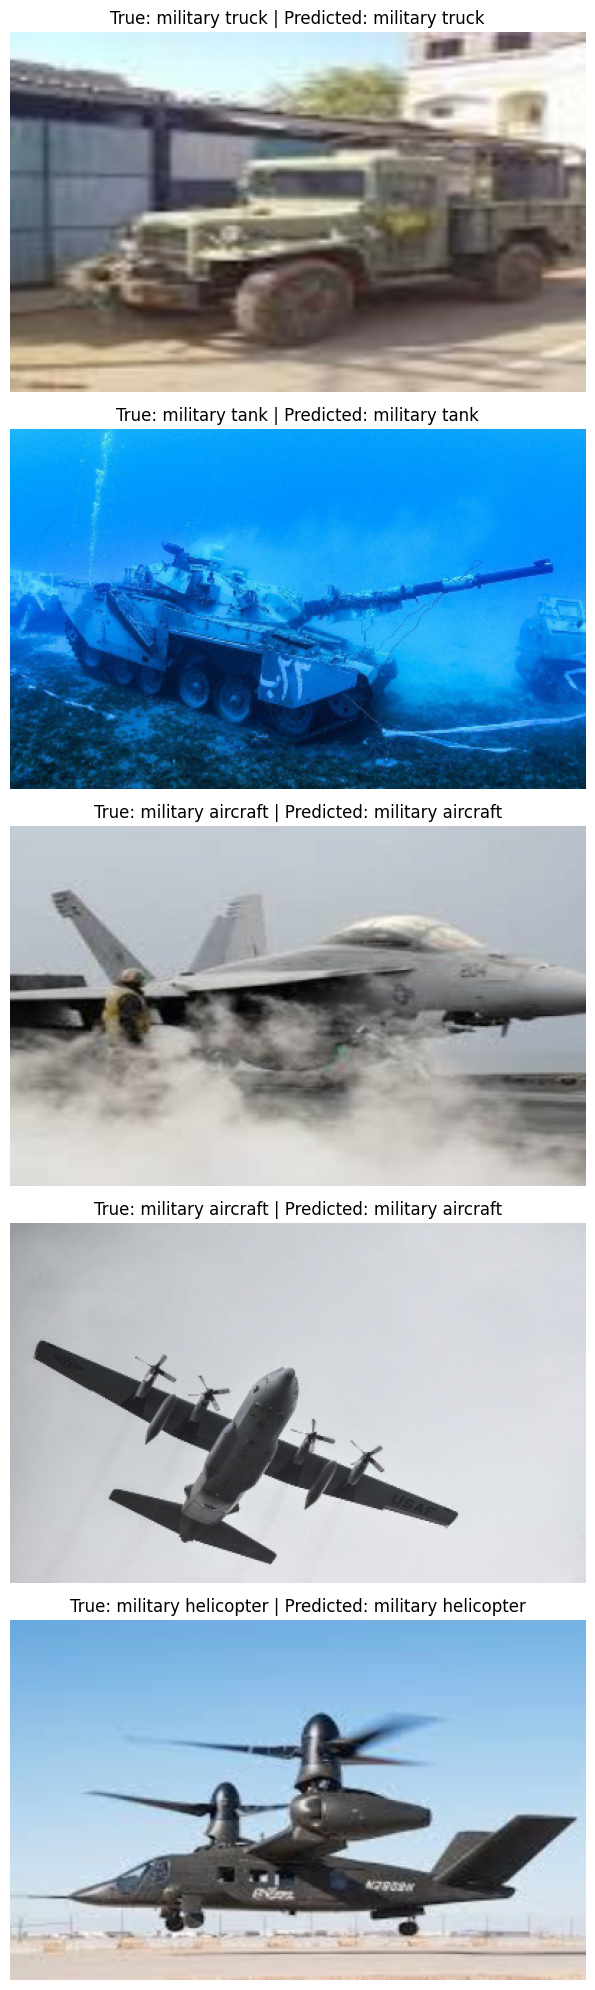

In [210]:
def visualize_predictions(model, test_dataset, num_samples=5):
    """Visualize model predictions on random test images"""
    model.eval()
    plt.figure(figsize=(20, 4*num_samples))
    
    # Get random indices
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    
    # Create a batch for inference
    batch_images = []
    batch_labels = []
    
    # Collect samples
    for sample_idx in indices:
        image, label = test_dataset[sample_idx]
        batch_images.append(image)
        batch_labels.append(label)
    
    # Stack into batches
    batch_images = torch.stack(batch_images)
    batch_labels = torch.tensor(batch_labels)
    
    # Get predictions for the batch
    with torch.no_grad():
        outputs = model(batch_images.to(device))
        predictions = torch.argmax(outputs.data, 1)
    
    # Visualize each sample
    for idx, (image, true_label, pred_label) in enumerate(zip(batch_images, batch_labels, predictions)):
        # Convert tensor to numpy for visualization
        img_np = image.permute(1, 2, 0).numpy()
        img_np = std * img_np + mean  # Denormalize
        img_np = np.clip(img_np, 0, 1)
        
        # Get class names
        true_class = test_dataset.classes[true_label]
        pred_class = test_dataset.classes[pred_label.cpu()]
        
        # Plot image
        plt.subplot(num_samples, 1, idx+1)
        plt.imshow(img_np)
        plt.title(f'True: {true_class} | Predicted: {pred_class}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('images/prediction_examples.png')
    plt.show()

visualize_predictions(ensemble_model, test_dataset)

## Results
- The best model was selected based on validation accuracy, achieving an overall accuracy of 90% on the test set. The classification report indicated strong performance across all vehicle categories, with precision, recall, and F1-scores above 0.87 for most classes.
- The ensemble model, which combined DenseNet121, ResNet50, and EfficientNetB0, further improved performance, achieving an accuracy of 93% on the test set. This demonstrates the effectiveness of combining multiple models to enhance prediction reliability.

## Conclusion
- The project was carried out with training using deep learning models for the classification of military and civilian vehicles.
- The project successfully demonstrated the application of deep learning techniques for image classification tasks, achieving satisfactory results with the selected models. The ensemble model, in particular, showcased the potential for improved accuracy through model combination.
- Future work could explore additional data augmentation techniques, experiment with more complex models, or apply the methodology to other image classification tasks.

## References

- [Mendeley Dataset](https://data.mendeley.com/datasets/njdjkbxdpn/1)

## Additional Folders

Additional Folders : 
- [Image and Label Folder](https://drive.google.com/drive/folders/19zN-tfE5l95oTFO84kqXiaULpq3qTusb)